# EDA for Gas Fees 

In this notebook we perform Exploratory Data Analysis (EDA) on FIL's gas fee mechanism. The goal is to observe the gas fee as a signal and attempt to understand what may be driving it. 

Access was obtained to Sentinel from Filecoin, we will use the the `derived_gas_outputs` table as the primary data gathering table. [Sentinel's Data Dictionary](https://github.com/filecoin-project/sentinel/blob/master/docs/db.md) was obtained on 6/28/2021 and will drive subsquent analysis. 


This notebook will do the following:

1. Analyze the `derived_gas_outputs` continuous signals for June 2021, mean aggregated by seconds.
2. Analyze the individual actors and methods for June 2021, and ascertain the most common methods, actors, and what drives gas usage.
3. Perform Fourier Analysis of the `derived_gas_outputs` continuous signals to understand phase shifts, periodicity, and leading indicators.
4. Combine the `derived_gas_outputs` with exogenous signals from the `chain_economics`, `chain_powers`, and `chain_rewards` tables. 
5. Perform a VAR analysis and Granger Causality on the key signals combined from #4. 
6. Generate conclusions from our research.

## Change Log

## TODO: 
* Decomposed Phase Shifts Overlay of specific exogenous chain signals with `derived_gas_outputs` 
* In-depth analysis of method distributions
    ** Distribution of the gas_used by tuple (actor, method), with the “top 10” above a threshold being presented/visualized (threshold could be exogenous or backed out from quantile analysis).
* In-depth Granger Causality analysis.
* Conclusions


## What are Gas Fees? 
Note: this description is copied from the [official Filecoin documentation](https://docs.filecoin.io/about-filecoin/how-filecoin-works/#gas-fees)

Executing messages, for example by including transactions or proofs in the chain, consumes both computation and storage resources on the network. Gas is a measure of resources consumed by messages. The gas consumed by a message directly affects the cost that the sender has to pay for it to be included in a new block by a miner.

Historically in other blockchains, miners specify a GasFee in a unit of native currency and then pay the block producing miners a priority fee based on how much gas is consumed by the message. Filecoin works similarly, except an amount of the fees is burned (sent to an irrecoverable address) to compensate for the network expenditure of resources, since all nodes need to validate the messages. The idea is based on Ethereum's EIP1559.

The amount of fees burned in the Filecoin network comes given by a dynamic BaseFee which gets automatically adjusted according to the network congestion parameters (block sizes). The current value can be obtained from one of the block explorers or by inspecting the current head.

Additionally, a number of gas-related parameters are attached to each message and determine the amount of rewards that miners get. Here's an overview of the terms and concepts:

**GasUsage**: the amount of gas that a message's execution actually consumes. Current protocol does not know how much gas a message will exactly consume ahead of execution, but it can be estimated (see prices (opens new window)). GasUsage measured in units of Gas.

**BaseFee**: the amount of FIL that gets burned per unit of gas consumed for the execution of every message. It is measured in units of attoFIL/Gas.

**GasLimit**: the limit on the amount of gas that a message's execution can consume, estimated and specified by a message sender. It is measured in units of Gas. The sum of GasLimit for all messages included in a block must not exceed the BlockGasLimit. Messages will fail to execute if they run out of Gas, and any effects of the execution will be reverted.

**GasFeeCap**: the maximum token amount that a sender is willing to pay per GasUnit for including a message in a block. It is measured in units of attoFIL/Gas. A message sender must have a minimum balance of GasFeeCap * GasLimit when sending a message, even though not all of that will be consumed. GasFeeCap can serve as a safeguard against high, unexpected BaseFee fluctuations.

**GasPremium**: a priority fee that is paid to the block-producing miner. This is capped by GasFeeCap. The BaseFee has a higher priority. It is measured in units of attoFIL/Gas and can be as low as 1 attoFIL/Gas.

**Overestimation burn**: an additional amount of gas to burn that grows larger when the difference between GasLimit and GasUsage is large. 

The total cost of a message for a sender will be:

* GasUsage * BaseFee FIL (burned) +
* GasLimit * GasPremium FIL (miner's reward) +
* OverEstimationBurn * BaseFee FIL

An important detail is that a message will always pay the burn fee, regardless of the GasFeeCap used. Thus, a low GasFeeCap may result in a reduced GasPremium or even a negative one! In that case, the miners that include a message will have to pay the needed amounts out of their own pockets, which means they are unlikely to include such messages in new blocks.

Filecoin implementations may choose the heuristics of how their miners select messages for inclusion in new blocks, but they will usually attempt to maximize the miner's rewards.


## Data Resources
* https://hackmd.io/5leND7tITX--5NJsFCJyow # Existing Sentinel queries 
* https://github.com/filecoin-project/sentinel/blob/master/docs/sentinel_tables_purpose.csv # Sentinel Tables Purpose


### Sentinel Diagram 
![](sentinel_diagram.png)

In [1]:
# import libraries
from sqlalchemy import create_engine
import pandas as pd
from datetime import datetime
from statsmodels.tsa.api import VAR
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.stattools import adfuller
from math import sqrt
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import numpy as np

from Cryptoeconomics_signal_processing import time_analysis, fourier_transform, phase_shift_overlay


%matplotlib inline

import warnings
warnings.simplefilter('ignore')



In [2]:
# load connection string
CONN_STRING_PATH = '../config/sentinel_conn_string_andrew.txt'


with open(CONN_STRING_PATH, 'r') as fid:
    conn_string = fid.read()
    
# create database connection.
connection = create_engine(conn_string, pool_recycle=3600).connect()



## Data EDA

Below we download minute averages from the `derived_gas_outputs` table from June 1st, 2021 to June 30th, 2021. After downloading the data, we few the first and lasts 5 rows, and perform basic statistics on the data.

### `derived_gas_outputs` - coped from [Sentinel's Data Dictionary](https://github.com/filecoin-project/sentinel/blob/master/docs/db.md)
Derived gas costs resulting from execution of a message in the VM.

|Name|Type|Nullable|Description|
|---|---|---|---|
|`actor_name`|`text`|NO|Human readable identifier for the type of the actor.|
|`base_fee_burn`|`text`|NO|The amount of FIL (in attoFIL) to burn as a result of the base fee. It is parent_base_fee (or gas_fee_cap if smaller) multiplied by gas_used. Note: successfull window PoSt messages are not charged this burn.|
|`cid`|`text`|NO|CID of the message.|
|`exit_code`|`bigint`|NO|The exit code that was returned as a result of executing the message. Exit code 0 indicates success. Codes 0-15 are reserved for use by the runtime. Codes 16-31 are common codes shared by different actors. Codes 32+ are actor specific.|
|`from`|`text`|NO|Address of actor that sent the message.|
|`gas_burned`|`bigint`|NO|The overestimated units of gas to burn. It is a portion of the difference between gas_limit and gas_used.|
|`gas_fee_cap`|`text`|NO|The maximum price that the message sender is willing to pay per unit of gas.|
|`gas_limit`|`bigint`|YES|A hard limit on the amount of gas (i.e., number of units of gas) that a message’s execution should be allowed to consume on chain. It is measured in units of gas.|
|`gas_premium`|`text`|NO|The price per unit of gas (measured in attoFIL/gas) that the message sender is willing to pay (on top of the BaseFee) to "tip" the miner that will include this message in a block.|
|`gas_refund`|`bigint`|NO|The overestimated units of gas to refund. It is a portion of the difference between gas_limit and gas_used.|
|`gas_used`|`bigint`|NO|A measure of the amount of resources (or units of gas) consumed, in order to execute a message.|
|`height`|`bigint`|NO|Epoch this message was executed at.|
|`method`|`bigint`|YES|The method number to invoke. Only unique to the actor the method is being invoked on. A method number of 0 is a plain token transfer - no method exectution.|
|`miner_penalty`|`text`|NO|Any penalty fees (in attoFIL) the miner incured while executing the message.|
|`miner_tip`|`text`|NO|The amount of FIL (in attoFIL) the miner receives for executing the message. Typically it is gas_premium * gas_limit but may be lower if the total fees exceed the gas_fee_cap.|
|`nonce`|`bigint`|YES|The message nonce, which protects against duplicate messages and multiple messages with the same values.|
|`over_estimation_burn`|`text`|NO|The fee to pay (in attoFIL) for overestimating the gas used to execute a message. The overestimated gas to burn (gas_burned) is a portion of the difference between gas_limit and gas_used. The over_estimation_burn value is gas_burned * parent_base_fee.|
|`parent_base_fee`|`text`|NO|The set price per unit of gas (measured in attoFIL/gas unit) to be burned (sent to an unrecoverable address) for every message execution.|
|`refund`|`text`|NO|The amount of FIL (in attoFIL) to refund to the message sender after base fee, miner tip and overestimation amounts have been deducted.|
|`size_bytes`|`bigint`|YES|Size in bytes of the serialized message.|
|`state_root`|`text`|NO|CID of the parent state root.|
|`to`|`text`|NO|Address of actor that received the message.|
|`value`|`text`|NO|The FIL value transferred (attoFIL) to the message receiver.|





In [3]:
QUERY = """
SELECT 
date_trunc('second', 
to_timestamp(height_to_unix(d.height))) AS timestamp,
AVG(CAST(gas_fee_cap AS FLOAT)) AS mean_gas_fee_cap,
AVG(CAST(gas_premium AS FLOAT))  as mean_gas_premium,
AVG(CAST(gas_limit AS FLOAT))  as mean_gas_limit,
AVG(CAST(gas_used AS FLOAT))  as mean_gas_used,
AVG(CAST(parent_base_fee AS FLOAT))  as mean_parent_base_fee,
AVG(CAST(base_fee_burn AS FLOAT))  as mean_base_fee_burn,
AVG(CAST(over_estimation_burn AS FLOAT))  as mean_over_estimation_burn,
AVG(CAST(gas_refund AS FLOAT))  as mean_gas_refund,
AVG(CAST(gas_burned AS FLOAT))  as mean_gas_burned
FROM derived_gas_outputs d
WHERE
to_timestamp(height_to_unix(d.height)) BETWEEN '2021-06-01' AND '2021-06-30'
GROUP BY
timestamp
"""
derived_gas_outputs_seconds = (pd.read_sql(QUERY, connection))
derived_gas_outputs_seconds

,timestamp,mean_gas_fee_cap,mean_gas_premium,mean_gas_limit,mean_gas_used,mean_parent_base_fee,mean_base_fee_burn,mean_over_estimation_burn,mean_gas_refund,mean_gas_burned
0,2021-06-01 00:00:00+00:00,9.780685e+09,100706.952922,3.817361e+07,3.133535e+07,111.0,3.450383e+09,1.455183e+08,5.527290e+06,1.310976e+06
1,2021-06-01 00:00:30+00:00,5.766888e+09,103047.672956,3.901113e+07,3.181447e+07,103.0,3.208506e+09,1.281268e+08,5.952711e+06,1.243950e+06
2,2021-06-01 00:01:00+00:00,7.398405e+09,99976.861111,3.363575e+07,2.711274e+07,102.0,2.690713e+09,1.291310e+08,5.257021e+06,1.265990e+06
3,2021-06-01 00:01:30+00:00,3.868522e+09,102065.719647,3.715926e+07,3.069589e+07,106.0,3.203752e+09,1.002643e+08,5.517480e+06,9.458897e+05
4,2021-06-01 00:02:00+00:00,1.404787e+09,101765.362069,3.992063e+07,3.259273e+07,107.0,3.438982e+09,1.363375e+08,6.053718e+06,1.274183e+06
...,...,...,...,...,...,...,...,...,...,...
82939,2021-06-29 23:58:00+00:00,1.585295e+09,78327.121766,3.439507e+07,2.810757e+07,100.0,2.754073e+09,1.375876e+08,4.911622e+06,1.375876e+06
82940,2021-06-29 23:58:30+00:00,2.293850e+09,99212.348285,3.760259e+07,3.033970e+07,100.0,2.914865e+09,1.671934e+08,5.590956e+06,1.671934e+06
82941,2021-06-29 23:59:00+00:00,2.009460e+09,101383.218182,3.718033e+07,3.066556e+07,100.0,2.988806e+09,1.121542e+08,5.393229e+06,1.121542e+06
82942,2021-06-29 23:59:30+00:00,1.778339e+09,103728.272251,3.542036e+07,2.813989e+07,100.0,2.728886e+09,1.670951e+08,5.609522e+06,1.670951e+06


In [4]:
derived_gas_outputs_seconds.describe()

,mean_gas_fee_cap,mean_gas_premium,mean_gas_limit,mean_gas_used,mean_parent_base_fee,mean_base_fee_burn,mean_over_estimation_burn,mean_gas_refund,mean_gas_burned
count,8.294400e+04,8.294400e+04,8.294400e+04,8.294400e+04,8.294400e+04,8.294400e+04,8.294400e+04,8.294400e+04,8.294400e+04
mean,8.528625e+09,1.339211e+06,3.979821e+07,3.215620e+07,5.349169e+08,1.703683e+16,9.682434e+14,5.803021e+06,1.838989e+06
std,5.598270e+09,9.646664e+06,5.243132e+06,2.558366e+06,5.205302e+08,1.674889e+16,1.623411e+15,5.811794e+05,4.187814e+06
min,5.746347e+08,7.597810e+04,2.102210e+07,1.250913e+07,1.000000e+02,1.609273e+09,6.882097e+07,1.679725e+06,4.727735e+05
25%,4.617155e+09,1.076026e+05,3.747379e+07,3.059439e+07,8.085207e+07,2.460031e+15,1.185683e+14,5.441471e+06,1.189778e+06
50%,7.911635e+09,1.986068e+05,3.916494e+07,3.187912e+07,4.434246e+08,1.403619e+16,6.202897e+14,5.734689e+06,1.472691e+06
75%,1.106594e+10,6.780385e+05,4.123416e+07,3.338498e+07,9.125038e+08,2.935162e+16,1.402984e+15,6.080691e+06,1.902601e+06
max,4.005927e+11,1.491589e+09,3.333089e+08,1.403822e+08,6.273926e+09,2.103278e+17,1.886474e+17,2.970918e+07,3.120059e+08


### Messages calculation mapping

Based on the message cost calculation outliend by Filecoin's official documentation, we will map the data obtained to this calculation.

Filecoin:
`message_cost_calculation =  GasUsage * BaseFee FIL (burned) + GasLimit * GasPremium FIL (miner reward) + OverEstimationBurn * BaseFee FIL`


Our downloaded data:
`message_cost = derived_gas_outputs.mean_gas_used * derived_gas_outputs.mean_base_fee_burn + derived_gas_outputs.mean_gas_limit * derived_gas_outputs.mean_gas_premium + derived_gas_outputs.mean_over_estimation_burn * derived_gas_outputs.mean_base_fee_burn`

In [5]:
# create field
derived_gas_outputs_seconds['mean_message_cost'] = derived_gas_outputs_seconds.mean_gas_used * derived_gas_outputs_seconds.mean_base_fee_burn + derived_gas_outputs_seconds.mean_gas_limit * derived_gas_outputs_seconds.mean_gas_premium + derived_gas_outputs_seconds.mean_over_estimation_burn * derived_gas_outputs_seconds.mean_base_fee_burn

We will focus on analyzing the methods by actor type using the derived gas outputs table. The data is very large, so we will perform individul SQL queries in order to obtain all of the required data.

In [6]:
# # message level data
QUERY = """
SELECT DISTINCT
d.actor_name,
d.method
FROM derived_gas_outputs d
WHERE
to_timestamp(height_to_unix(d.height)) BETWEEN '2021-06-01' AND '2021-06-30'
GROUP BY
d.actor_name,
d.method
"""
derived_gas_outputs_message_level_actors = (pd.read_sql(QUERY, connection))


Count of all actor types and methods used during June.

In [7]:
derived_gas_outputs_message_level_actors

,actor_name,method
0,fil/4/account,0
1,fil/4/account,2
2,fil/4/account,3
3,fil/4/account,5
4,fil/4/init,2
5,fil/4/multisig,0
6,fil/4/multisig,2
7,fil/4/multisig,3
8,fil/4/paymentchannel,0
9,fil/4/storagemarket,2


In order to understand what the specific methods signify, we have begun creating a mapping table from Filecoin's system code:

https://docs.google.com/spreadsheets/d/13sfwHtT1YO94a37JmA956a1HcFJ_FtMQegu1oTE3WaQ/edit#gid=0

Method types are not unique across actor types. Without having this formalized and connected to git commits, these values may be inaccurate.

In [10]:
# V1 - 6/27/2021
mapping = pd.read_csv('derived_gas_outputs_actor_name_methods_mapping - Mapping.csv')

Below we will query all Storage Market Actor transactions for June

In [11]:
# # message level data
QUERY = """
SELECT 
d.base_fee_burn,
d.exit_code,
d.gas_burned,
d.gas_fee_cap,
d.gas_limit,
d.gas_premium,
d.gas_refund,
d.gas_used,
d.height,
d.method,
d.miner_penalty,
d.miner_tip,
d.nonce,
d.over_estimation_burn,
d.parent_base_fee,
d.refund
FROM derived_gas_outputs d
WHERE
to_timestamp(height_to_unix(d.height)) BETWEEN '2021-06-01' AND '2021-06-30'
AND d.actor_name = 'fil/4/account'
"""

derived_gas_outputs_message_level_account = (pd.read_sql(QUERY, connection))



In [12]:
derived_gas_outputs_message_level_account.groupby('method').mean()

,base_fee_burn,exit_code,gas_burned,gas_fee_cap,gas_limit,gas_premium,gas_refund,gas_used,height,miner_penalty,miner_tip,nonce,over_estimation_burn,parent_base_fee,refund
method,,,,,,,,,,,,,,,
0,3.276506e+14,0.048151,3.905309e+05,7.416375e+09,1.135119e+06,2.133869e+06,108480.638951,636107.822262,847243.503569,4.648974e+09,2.915206e+12,70020.339366,1.935082e+14,5.187646e+08,7.538262e+15
2,2.514774e+14,0.000000,2.029350e+04,7.258516e+09,5.872525e+05,1.500536e+09,102323.000000,464636.000000,872746.500000,0.000000e+00,9.152645e+14,3.500000,9.261252e+12,5.506788e+08,3.012608e+15
3,1.709964e+13,3.000000,3.197410e+05,4.000971e+09,6.099600e+05,3.000971e+09,0.000000,290219.000000,883501.500000,0.000000e+00,1.830472e+15,7.500000,1.883906e+13,5.891977e+07,5.740213e+14
5,3.828031e+14,6.000000,1.162449e+06,1.256299e+10,1.487968e+06,9.934300e+04,0.000000,325519.000000,856726.000000,0.000000e+00,1.478192e+11,4.000000,1.367014e+15,1.175978e+09,1.694337e+16


In [13]:
# add column and subset dataframe
derived_gas_outputs_message_level_account['Actor_name'] = 'Account'
method_analysis_account = derived_gas_outputs_message_level_account[['Actor_name','method','gas_used']]

array([[<AxesSubplot:title={'center':'0'}>,
        <AxesSubplot:title={'center':'2'}>],
       [<AxesSubplot:title={'center':'3'}>,
        <AxesSubplot:title={'center':'5'}>]], dtype=object)

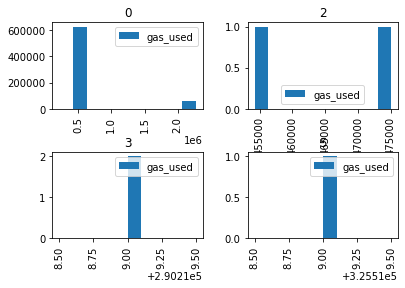

In [14]:
# x is the number of occurrences relative to the number of transactions. Y is the amount
derived_gas_outputs_message_level_account.hist(column='gas_used', by='method', grid=True, legend=True)

In [15]:
# # message level data
QUERY = """
SELECT 
d.base_fee_burn,
d.exit_code,
d.gas_burned,
d.gas_fee_cap,
d.gas_limit,
d.gas_premium,
d.gas_refund,
d.gas_used,
d.height,
d.method,
d.miner_penalty,
d.miner_tip,
d.nonce,
d.over_estimation_burn,
d.parent_base_fee,
d.refund
FROM derived_gas_outputs d
WHERE
to_timestamp(height_to_unix(d.height)) BETWEEN '2021-06-01' AND '2021-06-30'
AND d.actor_name = 'fil/4/init'
"""

derived_gas_outputs_message_level_init = (pd.read_sql(QUERY, connection))




In [16]:
# add column and subset dataframe
derived_gas_outputs_message_level_init['Actor_name'] = 'Init'
method_analysis_init = derived_gas_outputs_message_level_init[['Actor_name','method','gas_used']]

In [17]:
derived_gas_outputs_message_level_init.groupby('method').mean()

,base_fee_burn,exit_code,gas_burned,gas_fee_cap,gas_limit,gas_premium,gas_refund,gas_used,height,miner_penalty,miner_tip,nonce,over_estimation_burn,parent_base_fee,refund
method,,,,,,,,,,,,,,,
2,4.562901e+15,0.0,504798.334356,1.699623e+09,1.451766e+07,578496.006135,2.478518e+06,1.153434e+07,835169.542945,0.0,8.377153e+12,15296.48773,1.873967e+14,3.954663e+08,2.001330e+16


<AxesSubplot:title={'center':'2'}>

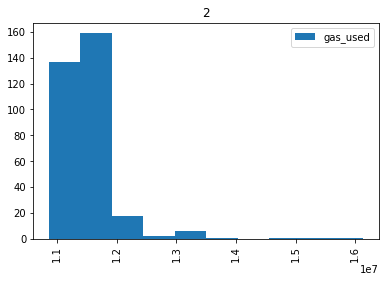

In [18]:
derived_gas_outputs_message_level_init.hist(column='gas_used', by='method', grid=True, legend=True)

In [19]:
# # message level data
QUERY = """
SELECT 
d.base_fee_burn,
d.exit_code,
d.gas_burned,
d.gas_fee_cap,
d.gas_limit,
d.gas_premium,
d.gas_refund,
d.gas_used,
d.height,
d.method,
d.miner_penalty,
d.miner_tip,
d.nonce,
d.over_estimation_burn,
d.parent_base_fee,
d.refund
FROM derived_gas_outputs d
WHERE
to_timestamp(height_to_unix(d.height)) BETWEEN '2021-06-01' AND '2021-06-30'
AND d.actor_name = 'fil/4/multisig'
"""

derived_gas_outputs_message_level_multisig = (pd.read_sql(QUERY, connection))

derived_gas_outputs_message_level_multisig.groupby('method').mean()



,base_fee_burn,exit_code,gas_burned,gas_fee_cap,gas_limit,gas_premium,gas_refund,gas_used,height,miner_penalty,miner_tip,nonce,over_estimation_burn,parent_base_fee,refund
method,,,,,,,,,,,,,,,
0,2.188468e+14,0.142857,6.321187e+05,4.176454e+09,1.195096e+06,297006.309524,8.870526e+04,4.742716e+05,839287.785714,0.0,2.946452e+11,7.756052e+04,4.358053e+14,4.583302e+08,7.293020e+15
2,2.040015e+15,0.007189,2.062038e+05,9.756442e+09,4.785633e+06,381075.815178,7.931002e+05,3.786329e+06,848270.992406,0.0,1.243136e+12,1.151697e+06,1.097651e+14,5.422300e+08,4.430711e+16
3,3.960730e+15,0.433925,3.344502e+06,5.756261e+09,1.310128e+07,679337.695266,1.835298e+06,7.921479e+06,847749.546351,0.0,1.139798e+13,2.022886e+03,1.747240e+15,5.948422e+08,5.296349e+16


In [20]:
# add column and subset dataframe
derived_gas_outputs_message_level_multisig['Actor_name'] = 'Multisig'
method_analysis_multisig = derived_gas_outputs_message_level_multisig[['Actor_name','method','gas_used']]

array([[<AxesSubplot:title={'center':'0'}>,
        <AxesSubplot:title={'center':'2'}>],
       [<AxesSubplot:title={'center':'3'}>, <AxesSubplot:>]], dtype=object)

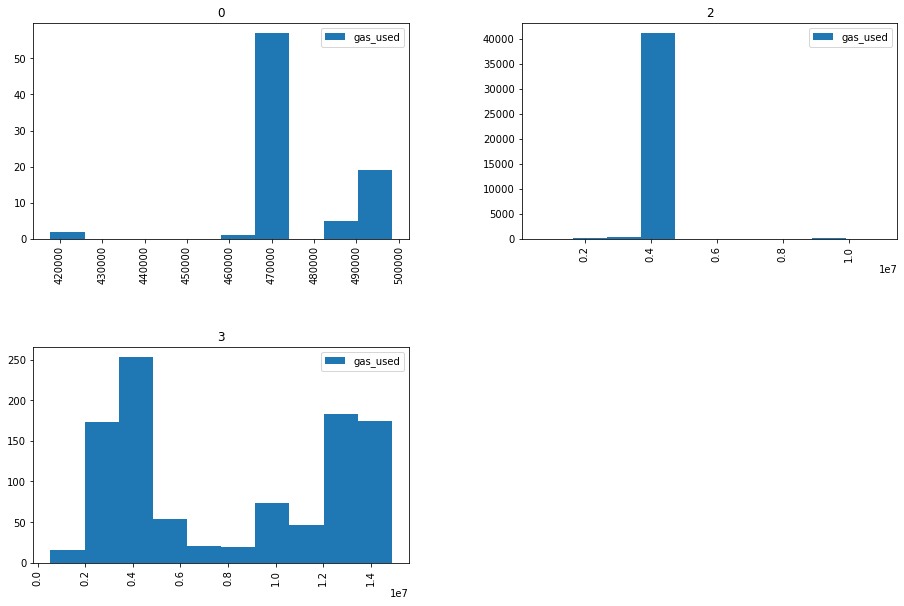

In [21]:
derived_gas_outputs_message_level_multisig.hist(column='gas_used', by='method', grid=True, legend=True,figsize=(15, 10))

In [22]:
# # message level data
QUERY = """
SELECT 
d.base_fee_burn,
d.exit_code,
d.gas_burned,
d.gas_fee_cap,
d.gas_limit,
d.gas_premium,
d.gas_refund,
d.gas_used,
d.height,
d.method,
d.miner_penalty,
d.miner_tip,
d.nonce,
d.over_estimation_burn,
d.parent_base_fee,
d.refund
FROM derived_gas_outputs d
WHERE
to_timestamp(height_to_unix(d.height)) BETWEEN '2021-06-01' AND '2021-06-30'
AND d.actor_name = 'fil/4/paymentchannel'
"""

derived_gas_outputs_message_level_paymentchannel = (pd.read_sql(QUERY, connection))

derived_gas_outputs_message_level_paymentchannel.groupby('method').mean()




,base_fee_burn,exit_code,gas_burned,gas_fee_cap,gas_limit,gas_premium,gas_refund,gas_used,height,miner_penalty,miner_tip,nonce,over_estimation_burn,parent_base_fee,refund
method,,,,,,,,,,,,,,,
0,1.267146e+14,0.0,16843.020833,2.838084e+09,582312.430556,474601.430556,98247.243056,467222.166667,836490.333333,0.0,2.825813e+11,672.819444,4.444308e+12,2.682490e+08,1.534041e+15


In [23]:
# add column and subset dataframe
derived_gas_outputs_message_level_paymentchannel['Actor_name'] = 'Paych'
method_analysis_paymentchannel = derived_gas_outputs_message_level_paymentchannel[['Actor_name','method','gas_used']]

<AxesSubplot:title={'center':'0'}>

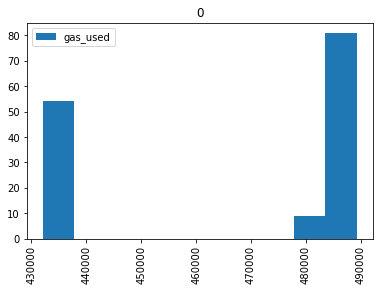

In [24]:
derived_gas_outputs_message_level_paymentchannel.hist(column='gas_used', by='method', grid=True, legend=True)

In [25]:
# # message level data
QUERY = """
SELECT 
d.base_fee_burn,
d.exit_code,
d.gas_burned,
d.gas_fee_cap,
d.gas_limit,
d.gas_premium,
d.gas_refund,
d.gas_used,
d.height,
d.method,
d.miner_penalty,
d.miner_tip,
d.nonce,
d.over_estimation_burn,
d.parent_base_fee,
d.refund
FROM derived_gas_outputs d
WHERE
to_timestamp(height_to_unix(d.height)) BETWEEN '2021-06-01' AND '2021-06-30'
AND d.actor_name = 'fil/4/storagemarket'
"""

derived_gas_outputs_message_level_storage_market = (pd.read_sql(QUERY, connection))

derived_gas_outputs_message_level_storage_market.groupby('method').mean()

,base_fee_burn,exit_code,gas_burned,gas_fee_cap,gas_limit,gas_premium,gas_refund,gas_used,height,miner_penalty,miner_tip,nonce,over_estimation_burn,parent_base_fee,refund
method,,,,,,,,,,,,,,,
2,5.457647e+15,0.000925,3.853708e+05,5.215361e+09,1.349888e+07,5.085374e+05,2.259325e+06,1.085418e+07,844361.406287,5.069182e+09,6.109533e+12,42092.246693,1.964198e+14,5.029221e+08,6.473099e+16
3,5.967836e+15,0.000000,1.135926e+07,2.702462e+09,2.490530e+07,1.379123e+06,2.301688e+06,1.124435e+07,835911.518519,0.000000e+00,3.000491e+14,3002.666667,1.649176e+16,5.279526e+08,4.851161e+16
4,1.062013e+17,0.026892,8.255802e+06,4.339762e+09,2.448419e+08,5.975343e+05,4.125410e+07,1.953320e+08,849925.583615,9.649538e+10,1.369516e+14,44573.308123,4.672200e+15,5.376320e+08,1.001502e+18


In [26]:
# add column and subset dataframe
derived_gas_outputs_message_level_storage_market['Actor_name'] = 'Market'
method_analysis_storage_market = derived_gas_outputs_message_level_storage_market[['Actor_name','method','gas_used']]

array([[<AxesSubplot:title={'center':'2'}>,
        <AxesSubplot:title={'center':'3'}>],
       [<AxesSubplot:title={'center':'4'}>, <AxesSubplot:>]], dtype=object)

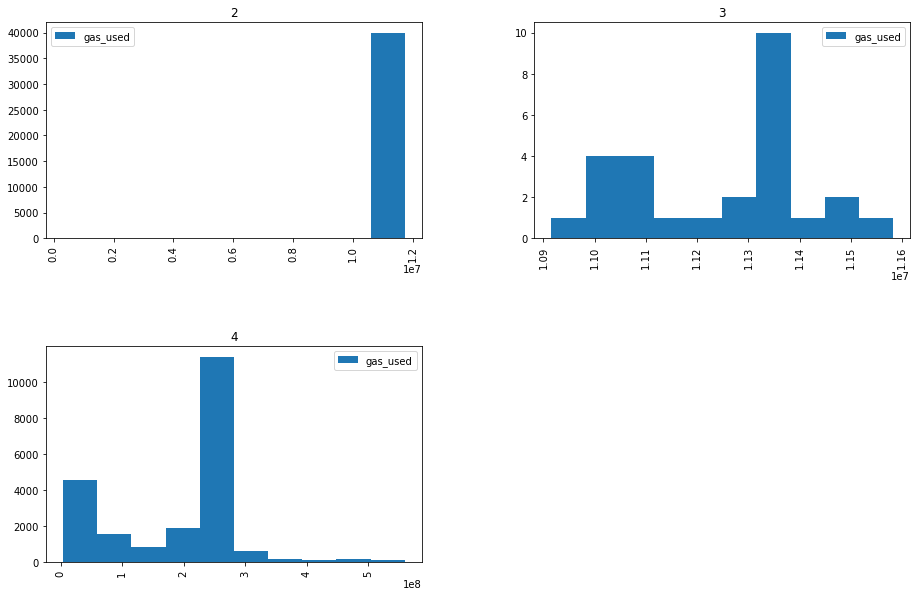

In [27]:
derived_gas_outputs_message_level_storage_market.hist(column='gas_used', by='method', grid=True, legend=True,figsize=(15, 10))

In [28]:
# # message level data
QUERY = """
SELECT 
d.base_fee_burn,
d.exit_code,
d.gas_burned,
d.gas_fee_cap,
d.gas_limit,
d.gas_premium,
d.gas_refund,
d.gas_used,
d.height,
d.method,
d.miner_penalty,
d.miner_tip,
d.nonce,
d.over_estimation_burn,
d.parent_base_fee,
d.refund
FROM derived_gas_outputs d
WHERE
to_timestamp(height_to_unix(d.height)) BETWEEN '2021-06-01' AND '2021-06-30'
AND d.actor_name = 'fil/4/storageminer'
"""

derived_gas_outputs_message_level_storageminer = (pd.read_sql(QUERY, connection))

derived_gas_outputs_message_level_storageminer.groupby('method').mean()


,base_fee_burn,exit_code,gas_burned,gas_fee_cap,gas_limit,gas_premium,gas_refund,gas_used,height,miner_penalty,miner_tip,nonce,over_estimation_burn,parent_base_fee,refund
method,,,,,,,,,,,,,,,
0,2.317586e+14,0.015132,1.039597e+05,8.508598e+09,6.094615e+05,5.196385e+07,6.043383e+04,4.450680e+05,845606.272383,0.000000e+00,2.743421e+13,250598.878941,4.192573e+13,5.215757e+08,6.041706e+15
3,1.018714e+15,0.037647,2.522873e+05,4.538837e+09,2.498503e+06,3.595904e+05,3.536981e+05,1.892518e+06,840951.148235,0.000000e+00,8.897498e+11,6346.202353,4.386998e+14,5.363686e+08,1.166256e+16
4,8.857037e+14,0.000000,4.550568e+04,4.316127e+09,2.094618e+06,2.506845e+07,3.199196e+05,1.729193e+06,854142.114428,0.000000e+00,5.148608e+13,19131.567164,2.007463e+13,5.114077e+08,8.021973e+15
5,2.090986e+12,0.052174,5.416701e+05,1.481479e+10,1.951331e+07,1.278225e+06,2.919959e+06,1.605168e+07,849218.262037,7.268571e+09,3.209957e+13,32408.758494,2.733301e+14,5.394798e+08,2.634189e+17
6,8.466247e+15,0.060147,6.497082e+05,8.364163e+09,1.961600e+07,1.137924e+06,3.056031e+06,1.591026e+07,848197.438629,4.311512e+10,6.547679e+13,457679.872828,2.961529e+14,5.221906e+08,2.111462e+17
7,2.697505e+16,0.079653,2.901167e+06,8.051357e+09,6.262548e+07,1.310913e+06,8.930783e+06,5.079353e+07,848283.267747,1.478731e+11,7.826155e+13,456641.888682,1.644682e+15,5.273738e+08,4.577854e+17
8,5.246719e+17,0.049065,7.101425e+07,2.082933e+09,2.371184e+09,1.580937e+05,4.022394e+08,1.897931e+09,848659.600467,0.000000e+00,2.399565e+14,137986.007009,1.971739e+16,3.450730e+08,1.166316e+18
9,2.658947e+16,0.060381,2.180467e+07,2.647235e+09,5.905758e+07,1.799370e+07,6.239015e+06,3.101389e+07,857117.569261,3.201805e+13,1.415201e+15,11626.890216,2.316559e+16,8.594860e+08,1.446739e+17
10,2.887503e+16,0.000000,1.162272e+06,1.024684e+10,4.054383e+07,9.952500e+04,6.828193e+06,3.255336e+07,874078.000000,0.000000e+00,4.035124e+12,2664.000000,1.030942e+15,8.870060e+08,3.855359e+17


In [29]:
# add column and subset dataframe
derived_gas_outputs_message_level_storageminer['Actor_name'] = 'Miner'
method_analysis_storageminer = derived_gas_outputs_message_level_storageminer[['Actor_name','method','gas_used']]

array([[<AxesSubplot:title={'center':'0'}>,
        <AxesSubplot:title={'center':'3'}>,
        <AxesSubplot:title={'center':'4'}>,
        <AxesSubplot:title={'center':'5'}>],
       [<AxesSubplot:title={'center':'6'}>,
        <AxesSubplot:title={'center':'7'}>,
        <AxesSubplot:title={'center':'8'}>,
        <AxesSubplot:title={'center':'9'}>],
       [<AxesSubplot:title={'center':'10'}>,
        <AxesSubplot:title={'center':'11'}>,
        <AxesSubplot:title={'center':'15'}>,
        <AxesSubplot:title={'center':'16'}>],
       [<AxesSubplot:title={'center':'18'}>,
        <AxesSubplot:title={'center':'20'}>,
        <AxesSubplot:title={'center':'21'}>,
        <AxesSubplot:title={'center':'22'}>],
       [<AxesSubplot:title={'center':'23'}>,
        <AxesSubplot:title={'center':'24'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

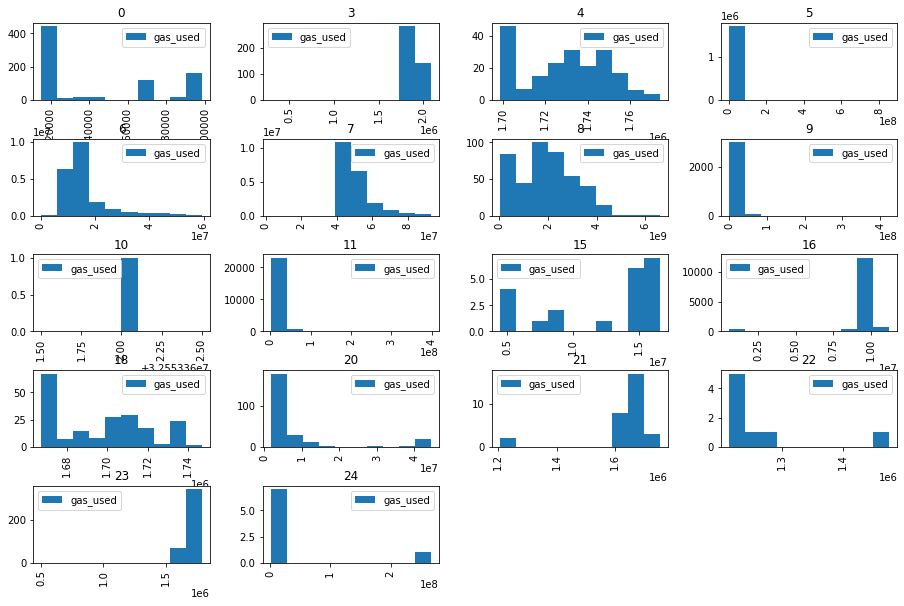

In [30]:
derived_gas_outputs_message_level_storageminer.hist(column='gas_used', by='method', grid=True, legend=True,figsize=(15, 10))

In [31]:
# # message level data
QUERY = """
SELECT 
d.base_fee_burn,
d.exit_code,
d.gas_burned,
d.gas_fee_cap,
d.gas_limit,
d.gas_premium,
d.gas_refund,
d.gas_used,
d.height,
d.method,
d.miner_penalty,
d.miner_tip,
d.nonce,
d.over_estimation_burn,
d.parent_base_fee,
d.refund
FROM derived_gas_outputs d
WHERE
to_timestamp(height_to_unix(d.height)) BETWEEN '2021-06-01' AND '2021-06-30'
AND d.actor_name = 'fil/4/storagepower'
"""

derived_gas_outputs_message_level_storagepower = (pd.read_sql(QUERY, connection))

derived_gas_outputs_message_level_storagepower.groupby('method').mean()



,base_fee_burn,exit_code,gas_burned,gas_fee_cap,gas_limit,gas_premium,gas_refund,gas_used,height,miner_penalty,miner_tip,nonce,over_estimation_burn,parent_base_fee,refund
method,,,,,,,,,,,,,,,
2,6.102287e+15,0.006744,1.107920e+06,1.234660e+09,3.365383e+07,1.316095e+07,5.621022e+06,2.692489e+07,863065.300578,0.0,3.752344e+14,1791.004817,2.971277e+14,2.276626e+08,3.446336e+16


In [32]:
# add column and subset dataframe
derived_gas_outputs_message_level_storagepower['Actor_name'] = 'Power'
method_analysis_storagepower = derived_gas_outputs_message_level_storagepower[['Actor_name','method','gas_used']]

<AxesSubplot:title={'center':'2'}>

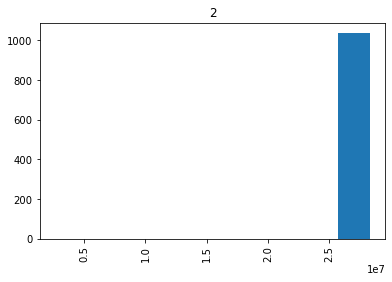

In [33]:
derived_gas_outputs_message_level_storagepower.hist(column='gas_used', by='method')

In [34]:
# # message level data
QUERY = """
SELECT 
d.base_fee_burn,
d.exit_code,
d.gas_burned,
d.gas_fee_cap,
d.gas_limit,
d.gas_premium,
d.gas_refund,
d.gas_used,
d.height,
d.method,
d.miner_penalty,
d.miner_tip,
d.nonce,
d.over_estimation_burn,
d.parent_base_fee,
d.refund
FROM derived_gas_outputs d
WHERE
to_timestamp(height_to_unix(d.height)) BETWEEN '2021-06-01' AND '2021-06-30'
AND d.actor_name = 'fil/4/verifiedregistry'
"""

derived_gas_outputs_message_level_verifiedregistry = (pd.read_sql(QUERY, connection))

derived_gas_outputs_message_level_verifiedregistry.groupby('method').mean()



,base_fee_burn,exit_code,gas_burned,gas_fee_cap,gas_limit,gas_premium,gas_refund,gas_used,height,miner_penalty,miner_tip,nonce,over_estimation_burn,parent_base_fee,refund
method,,,,,,,,,,,,,,,
4,2.769308e+15,0.0,209199.22,5.130172e+09,7098782.22,407449.98,1201560.86,5688022.14,848608.54,0.0,2.874231e+12,246.08,1.025164e+14,4.911572e+08,3.319940e+16


In [35]:
# add column and subset dataframe
derived_gas_outputs_message_level_verifiedregistry['Actor_name'] = 'Verified Registry'
method_analysis_verifiedregistry = derived_gas_outputs_message_level_verifiedregistry[['Actor_name','method','gas_used']]

Text(0.5, 1.0, 'Verified Registry Actor')

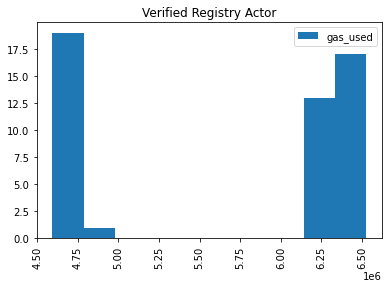

In [36]:
derived_gas_outputs_message_level_verifiedregistry.hist(column='gas_used', by='method', grid=True, legend=True)
plt.title('Verified Registry Actor')

In [37]:
method_analysis = pd.concat([method_analysis_paymentchannel,method_analysis_multisig,
                             method_analysis_init,method_analysis_account,method_analysis_storagepower,
                             method_analysis_verifiedregistry,method_analysis_storageminer,
                             method_analysis_storage_market])

In [38]:
mapping.fillna(0,inplace=True)

mapping['Method number'] = mapping['Method number'].astype(int)

In [39]:
mapping.head()

,Actor_name,Derived_gas_ouputs_name,Actor_description,Method number,Method,Method_description,Reference
0,Market,fil/4/storagemarket,0.0,0,Constructor,0.0,https://github.com/filecoin-project/specs-acto...
1,Market,fil/4/storagemarket,0.0,2,AddBalance,0.0,https://github.com/filecoin-project/specs-acto...
2,Market,fil/4/storagemarket,0.0,3,WithdrawBalance,0.0,https://github.com/filecoin-project/specs-acto...
3,Market,fil/4/storagemarket,0.0,4,PublishStorageDeals,0.0,https://github.com/filecoin-project/specs-acto...
4,Market,fil/4/storagemarket,0.0,5,VerifyDealsForActivation,0.0,https://github.com/filecoin-project/specs-acto...


In [40]:
method_analysis = pd.merge(method_analysis, mapping,  how='left', left_on=['Actor_name','method'], 
                           right_on = ['Actor_name','Method number'])


In [41]:
method_analysis.head()

,Actor_name,method,gas_used,Derived_gas_ouputs_name,Actor_description,Method number,Method,Method_description,Reference
0,Paych,0,432068,fil/4/paymentchannel,0.0,0.0,Constructor,0.0,https://github.com/filecoin-project/specs-acto...
1,Paych,0,486668,fil/4/paymentchannel,0.0,0.0,Constructor,0.0,https://github.com/filecoin-project/specs-acto...
2,Paych,0,432068,fil/4/paymentchannel,0.0,0.0,Constructor,0.0,https://github.com/filecoin-project/specs-acto...
3,Paych,0,432068,fil/4/paymentchannel,0.0,0.0,Constructor,0.0,https://github.com/filecoin-project/specs-acto...
4,Paych,0,432068,fil/4/paymentchannel,0.0,0.0,Constructor,0.0,https://github.com/filecoin-project/specs-acto...


In [42]:
method_analysis_subset = method_analysis[['gas_used','Method']] # Actor_name'

array([[<AxesSubplot:title={'center':'AddBalance'}>,
        <AxesSubplot:title={'center':'AddVerifiedClient'}>,
        <AxesSubplot:title={'center':'Approve'}>,
        <AxesSubplot:title={'center':'ChangeMultiaddrs'}>,
        <AxesSubplot:title={'center':'ChangeOwnerAddress'}>],
       [<AxesSubplot:title={'center':'ChangePeerID'}>,
        <AxesSubplot:title={'center':'ChangeWorkerAddress'}>,
        <AxesSubplot:title={'center':'CompactSectorNumbers'}>,
        <AxesSubplot:title={'center':'ConfirmUpdateWorkerKey'}>,
        <AxesSubplot:title={'center':'Constructor'}>],
       [<AxesSubplot:title={'center':'CreateMiner'}>,
        <AxesSubplot:title={'center':'DeclareFaults'}>,
        <AxesSubplot:title={'center':'DeclareFaultsRecovered'}>,
        <AxesSubplot:title={'center':'DisputeWindowedPoSt'}>,
        <AxesSubplot:title={'center':'Exec'}>],
       [<AxesSubplot:title={'center':'ExtendSectorExpiration'}>,
        <AxesSubplot:title={'center':'PreCommitSector'}>,
        

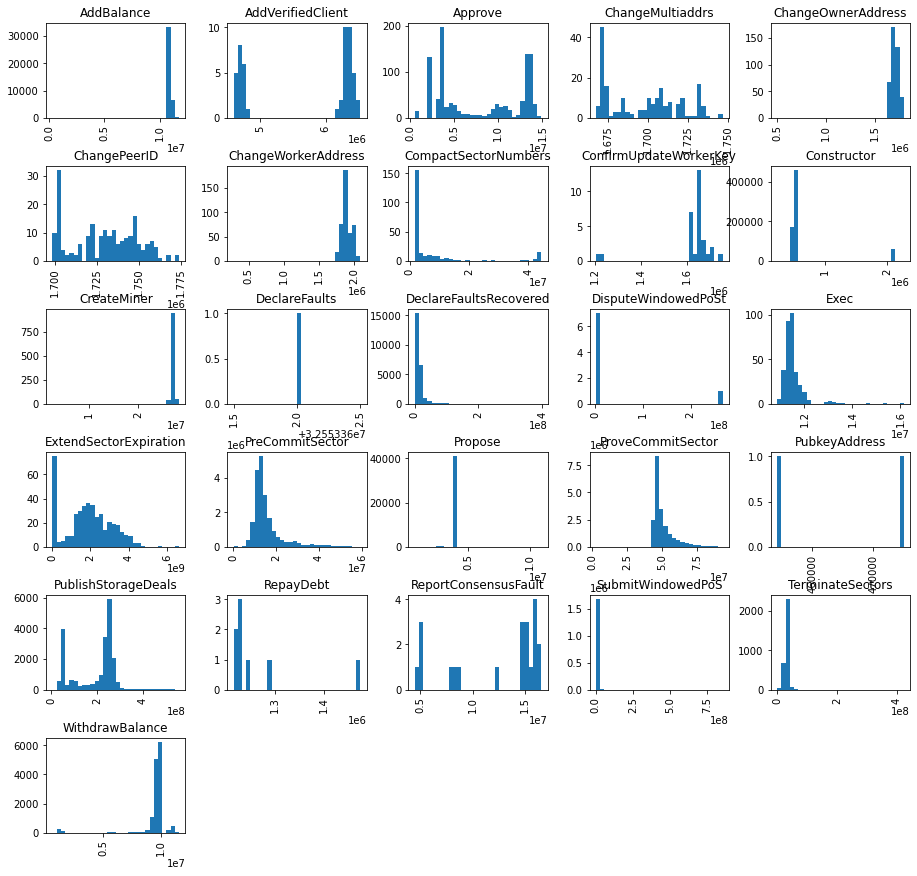

In [43]:
method_analysis_subset.hist(by='Method',bins=30, figsize=(15, 15))

## Time Analysis

When examining the derived_gas_outputs_message_level, we developed the following two questions:
1. Is the distribution of intervals between data points consistent?
2. What type of samplimg time do we have? 

<!-- Write out workflow for analyzing blockchain dataset. Flow chart for what is natural, etc -->
Workflow:
    1. Verify sampling intervals
    2. Verify distributions. If not normal, poisson, etc

To answer these questions, we will calculate the timestamp difference and create a histogram of the time differences and determine if we have equal time sampling or not.

In [44]:
derived_gas_outputs_seconds['time'] = derived_gas_outputs_seconds['timestamp'].apply(lambda x: x.value)

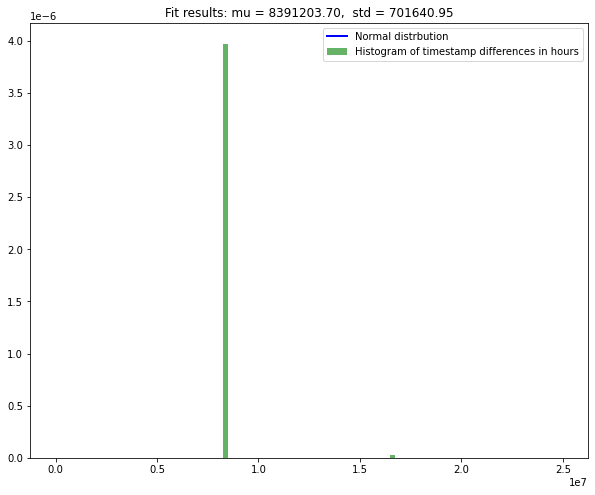

In [45]:
time_analysis(derived_gas_outputs_seconds,'time')

## Exogenous signals

https://github.com/filecoin-project/sentinel/blob/master/docs/db.md

## `chain_economics`
Economic summaries per state root CID.

|Name|Type|Nullable|Description|
|---|---|---|---|
|`burnt_fil`|`text`|NO|Total FIL (attoFIL) burned as part of penalties and on-chain computations.|
|`circulating_fil`|`text`|NO|The amount of FIL (attoFIL) circulating and tradeable in the economy. The basis for Market Cap calculations.|
|`locked_fil`|`text`|NO|The amount of FIL (attoFIL) locked as part of mining, deals, and other mechanisms.|
|`mined_fil`|`text`|NO|The amount of FIL (attoFIL) that has been mined by storage miners.|
|`parent_state_root`|`text`|NO|CID of the parent state root.|
|`vested_fil`|`text`|NO|Total amount of FIL (attoFIL) that is vested from genesis allocation.|


## `chain_powers`
Power summaries from the Power actor.

|Name|Type|Nullable|Description|
|---|---|---|---|
|`height`|`bigint`|NO|Epoch this power summary applies to.|
|`miner_count`|`bigint`|YES|Total number of miners.|
|`participating_miner_count`|`bigint`|YES|Total number of miners with power above the minimum miner threshold.|
|`qa_smoothed_position_estimate`|`text`|NO|Total power smoothed position estimate - Alpha Beta Filter "position" (value) estimate in Q.128 format.|
|`qa_smoothed_velocity_estimate`|`text`|NO|Total power smoothed velocity estimate - Alpha Beta Filter "velocity" (rate of change of value) estimate in Q.128 format.|
|`state_root`|`text`|NO|CID of the parent state root.|
|`total_pledge_collateral`|`text`|NO|Total locked FIL (attoFIL) miners have pledged as collateral in order to participate in the economy.|
|`total_qa_bytes_committed`|`text`|NO|Total provably committed, quality adjusted storage power in bytes. Quality adjusted power is a weighted average of the quality of its space and it is based on the size, duration and quality of its deals.|
|`total_qa_bytes_power`|`text`|NO|Total quality adjusted storage power in bytes in the network. Quality adjusted power is a weighted average of the quality of its space and it is based on the size, duration and quality of its deals.|
|`total_raw_bytes_committed`|`text`|NO|Total provably committed storage power in bytes. Raw byte power is the size of a sector in bytes.|
|`total_raw_bytes_power`|`text`|NO|Total storage power in bytes in the network. Raw byte power is the size of a sector in bytes.|


## `chain_rewards`
Reward summaries from the Reward actor.

|Name|Type|Nullable|Description|
|---|---|---|---|
|`cum_sum_baseline`|`text`|NO|Target that CumsumRealized needs to reach for EffectiveNetworkTime to increase. It is measured in byte-epochs (space * time) representing power committed to the network for some duration.|
|`cum_sum_realized`|`text`|NO|Cumulative sum of network power capped by BaselinePower(epoch). It is measured in byte-epochs (space * time) representing power committed to the network for some duration.|
|`effective_baseline_power`|`text`|NO|The baseline power (in bytes) at the EffectiveNetworkTime epoch.|
|`effective_network_time`|`bigint`|YES|Ceiling of real effective network time "theta" based on CumsumBaselinePower(theta) == CumsumRealizedPower. Theta captures the notion of how much the network has progressed in its baseline and in advancing network time.|
|`height`|`bigint`|NO|Epoch this rewards summary applies to.|
|`new_baseline_power`|`text`|NO|The baseline power (in bytes) the network is targeting.|
|`new_reward`|`text`|YES|The reward to be paid in per WinCount to block producers. The actual reward total paid out depends on the number of winners in any round. This value is recomputed every non-null epoch and used in the next non-null epoch.|
|`new_reward_smoothed_position_estimate`|`text`|NO|Smoothed reward position estimate - Alpha Beta Filter "position" (value) estimate in Q.128 format.|
|`new_reward_smoothed_velocity_estimate`|`text`|NO|Smoothed reward velocity estimate - Alpha Beta Filter "velocity" (rate of change of value) estimate in Q.128 format.|
|`state_root`|`text`|NO|CID of the parent state root.|
|`total_mined_reward`|`text`|NO|The total FIL (attoFIL) awarded to block miners.|

In [46]:
QUERY = """
SELECT 
date_trunc('second', 
to_timestamp(height_to_unix(cr.height))) AS timestamp,
AVG(CAST(cr.cum_sum_baseline AS FLOAT)) AS mean_cum_sum_baseline,
AVG(CAST(cr.cum_sum_realized AS FLOAT)) AS mean_cum_sum_realized,
AVG(CAST(cr.effective_baseline_power AS FLOAT)) AS mean_effective_baseline_power,
AVG(CAST(cr.effective_network_time AS FLOAT)) AS mean_effective_network_time,
AVG(CAST(cr.new_baseline_power AS FLOAT)) AS mean_new_baseline_power,
AVG(CAST(cr.new_reward AS FLOAT)) AS mean_new_reward,
AVG(CAST(cr.new_reward_smoothed_position_estimate AS FLOAT)) AS mean_new_reward_smoothed_position_estimate,
AVG(CAST(cr.new_reward_smoothed_velocity_estimate AS FLOAT)) AS mean_new_reward_smoothed_velocity_estimate,
AVG(CAST(cr.total_mined_reward AS FLOAT)) AS mean_total_mined_reward,
AVG(CAST(cp.miner_count AS FLOAT)) AS mean_miner_count,
AVG(CAST(cp.participating_miner_count AS FLOAT)) AS mean_participating_miner_count,
AVG(CAST(cp.qa_smoothed_position_estimate AS FLOAT)) AS mean_qa_smoothed_position_estimate,
AVG(CAST(cp.qa_smoothed_velocity_estimate AS FLOAT)) AS mean_qa_smoothed_velocity_estimate,
AVG(CAST(cp.total_pledge_collateral AS FLOAT)) AS mean_total_pledge_collateral,
AVG(CAST(cp.total_qa_bytes_committed AS FLOAT)) AS mean_total_qa_bytes_committed,
AVG(CAST(cp.total_qa_bytes_power AS FLOAT)) AS mean_total_qa_bytes_power,
AVG(CAST(cp.total_raw_bytes_committed AS FLOAT)) AS mean_total_raw_bytes_committed,
AVG(CAST(cp.total_raw_bytes_power AS FLOAT)) AS mean_total_raw_bytes_power,
AVG(CAST(ce.burnt_fil AS FLOAT)) AS mean_burnt_fil,
AVG(CAST(ce.circulating_fil AS FLOAT)) AS mean_circulating_fil,
AVG(CAST(ce.locked_fil AS FLOAT)) AS mean_locked_fil,
AVG(CAST(ce.mined_fil AS FLOAT)) AS mean_mined_fil,
AVG(CAST(ce.vested_fil AS FLOAT)) AS mean_vested_fil
FROM chain_rewards cr
LEFT JOIN chain_powers cp
ON cr.state_root = cp.state_root
LEFT JOIN chain_economics ce
ON cr.state_root = ce.parent_state_root
WHERE
to_timestamp(height_to_unix(cr.height)) BETWEEN '2021-06-01' AND '2021-06-30'
GROUP BY
timestamp
"""
chain_economics_seconds = (pd.read_sql(QUERY, connection))


In [47]:
chain_economics_seconds.describe()

,mean_cum_sum_baseline,mean_cum_sum_realized,mean_effective_baseline_power,mean_effective_network_time,mean_new_baseline_power,mean_new_reward,mean_new_reward_smoothed_position_estimate,mean_new_reward_smoothed_velocity_estimate,mean_total_mined_reward,mean_miner_count,...,mean_total_pledge_collateral,mean_total_qa_bytes_committed,mean_total_qa_bytes_power,mean_total_raw_bytes_committed,mean_total_raw_bytes_power,mean_burnt_fil,mean_circulating_fil,mean_locked_fil,mean_mined_fil,mean_vested_fil
count,8.240100e+04,8.240100e+04,8.240100e+04,82401.000000,8.240100e+04,8.240100e+04,8.240100e+04,8.240100e+04,8.240100e+04,82401.000000,...,8.240100e+04,8.240100e+04,8.240100e+04,8.240100e+04,8.240100e+04,8.240100e+04,8.240100e+04,8.240100e+04,8.240100e+04,8.240100e+04
mean,2.109790e+24,2.109788e+24,4.280056e+18,595885.731229,5.054468e+18,1.264404e+20,4.302543e+58,-9.172486e+51,7.571850e+25,541479.141260,...,8.259055e+25,7.375889e+18,7.375447e+18,7.373563e+18,7.373132e+18,2.645154e+25,1.348089e+26,8.259967e+25,7.571850e+25,1.510749e+26
std,1.214419e+23,1.214418e+23,8.007711e+16,28373.441428,8.007708e+16,6.462624e+17,2.199112e+56,1.339369e+50,2.980869e+24,166.390213,...,2.396281e+24,3.515476e+17,3.515673e+17,3.513946e+17,3.514104e+17,2.913225e+23,3.342681e+24,2.396894e+24,2.980869e+24,3.045394e+24
min,1.901761e+24,1.901758e+24,4.142884e+18,546751.000000,4.917297e+18,1.253207e+20,4.264439e+58,-9.407656e+51,7.054874e+25,541144.000000,...,7.830897e+25,6.721132e+18,6.720618e+18,6.719005e+18,6.718506e+18,2.604027e+25,1.290679e+26,7.831719e+25,7.054874e+25,1.458100e+26
25%,2.004465e+24,2.004464e+24,4.210606e+18,571341.000000,4.985019e+18,1.258827e+20,4.283565e+58,-9.287933e+51,7.313919e+25,541360.000000,...,8.054311e+25,7.101623e+18,7.101163e+18,7.099413e+18,7.098968e+18,2.613118e+25,1.319620e+26,8.055162e+25,7.313919e+25,1.484394e+26
50%,2.108625e+24,2.108624e+24,4.279288e+18,595879.000000,5.053701e+18,1.264368e+20,4.302420e+58,-9.170918e+51,7.571901e+25,541484.000000,...,8.264366e+25,7.389522e+18,7.389122e+18,7.387171e+18,7.386786e+18,2.646702e+25,1.347357e+26,8.265277e+25,7.571901e+25,1.510699e+26
75%,2.214102e+24,2.214101e+24,4.348838e+18,620329.000000,5.123251e+18,1.269985e+20,4.321534e+58,-9.056701e+51,7.828785e+25,541568.000000,...,8.467215e+25,7.684772e+18,7.684364e+18,7.682284e+18,7.681877e+18,2.671940e+25,1.376507e+26,8.468180e+25,7.828785e+25,1.536974e+26
max,2.323972e+24,2.323970e+24,4.421284e+18,645385.000000,5.195697e+18,1.275672e+20,4.340886e+58,-8.942058e+51,8.090919e+25,542181.000000,...,8.661510e+25,7.967573e+18,7.967125e+18,7.964992e+18,7.964557e+18,2.685018e+25,1.408978e+26,8.662520e+25,8.090919e+25,1.563967e+26


In [48]:
chain_economics_seconds.fillna(0,inplace=True)

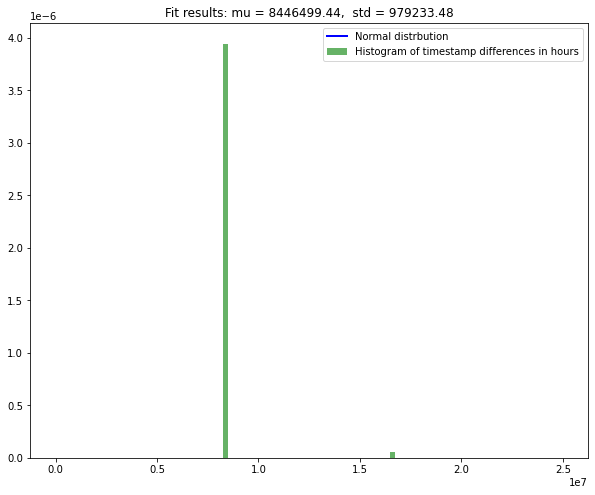

In [49]:
chain_economics_seconds['time'] = chain_economics_seconds['timestamp'].apply(lambda x: x.value)

time_analysis(chain_economics_seconds,'time')

In [50]:
# remove duplicated columns 
del derived_gas_outputs_seconds['time']
del derived_gas_outputs_seconds['timestampDiff']

del chain_economics_seconds['time']
del chain_economics_seconds['timestampDiff']

In [51]:
# combine signals
combined = derived_gas_outputs_seconds.merge(chain_economics_seconds,how='left',on='timestamp')
combined.describe()

,mean_gas_fee_cap,mean_gas_premium,mean_gas_limit,mean_gas_used,mean_parent_base_fee,mean_base_fee_burn,mean_over_estimation_burn,mean_gas_refund,mean_gas_burned,mean_message_cost,...,mean_total_pledge_collateral,mean_total_qa_bytes_committed,mean_total_qa_bytes_power,mean_total_raw_bytes_committed,mean_total_raw_bytes_power,mean_burnt_fil,mean_circulating_fil,mean_locked_fil,mean_mined_fil,mean_vested_fil
count,8.294400e+04,8.294400e+04,8.294400e+04,8.294400e+04,8.294400e+04,8.294400e+04,8.294400e+04,8.294400e+04,8.294400e+04,8.294400e+04,...,8.239700e+04,8.239700e+04,8.239700e+04,8.239700e+04,8.239700e+04,8.239700e+04,8.239700e+04,8.239700e+04,8.239700e+04,8.239700e+04
mean,8.528625e+09,1.339211e+06,3.979821e+07,3.215620e+07,5.349169e+08,1.703683e+16,9.682434e+14,5.803021e+06,1.838989e+06,3.307282e+31,...,8.259046e+25,7.375876e+18,7.375434e+18,7.373550e+18,7.373119e+18,2.645153e+25,1.348087e+26,8.259958e+25,7.571839e+25,1.510748e+26
std,5.598270e+09,9.646664e+06,5.243132e+06,2.558366e+06,5.205302e+08,1.674889e+16,1.623411e+15,5.811794e+05,4.187814e+06,1.040050e+32,...,2.396276e+24,3.515469e+17,3.515666e+17,3.513939e+17,3.514096e+17,2.913220e+23,3.342668e+24,2.396889e+24,2.980860e+24,3.045384e+24
min,5.746347e+08,7.597810e+04,2.102210e+07,1.250913e+07,1.000000e+02,1.609273e+09,6.882097e+07,1.679725e+06,4.727735e+05,2.248460e+17,...,7.830897e+25,6.721132e+18,6.720618e+18,6.719005e+18,6.718506e+18,2.604027e+25,1.290679e+26,7.831719e+25,7.054874e+25,1.458100e+26
25%,4.617155e+09,1.076026e+05,3.747379e+07,3.059439e+07,8.085207e+07,2.460031e+15,1.185683e+14,5.441471e+06,1.189778e+06,3.048616e+29,...,8.054309e+25,7.101623e+18,7.101163e+18,7.099413e+18,7.098968e+18,2.613117e+25,1.319618e+26,8.055161e+25,7.313908e+25,1.484393e+26
50%,7.911635e+09,1.986068e+05,3.916494e+07,3.187912e+07,4.434246e+08,1.403619e+16,6.202897e+14,5.734689e+06,1.472691e+06,8.647578e+30,...,8.264349e+25,7.389502e+18,7.389102e+18,7.387150e+18,7.386766e+18,2.646701e+25,1.347357e+26,8.265260e+25,7.571891e+25,1.510697e+26
75%,1.106594e+10,6.780385e+05,4.123416e+07,3.338498e+07,9.125038e+08,2.935162e+16,1.402984e+15,6.080691e+06,1.902601e+06,4.069624e+31,...,8.467199e+25,7.684772e+18,7.684364e+18,7.682284e+18,7.681877e+18,2.671938e+25,1.376506e+26,8.468165e+25,7.828775e+25,1.536973e+26
max,4.005927e+11,1.491589e+09,3.333089e+08,1.403822e+08,6.273926e+09,2.103278e+17,1.886474e+17,2.970918e+07,3.120059e+08,8.550888e+33,...,8.661510e+25,7.967573e+18,7.967125e+18,7.964992e+18,7.964557e+18,2.685018e+25,1.408978e+26,8.662520e+25,8.090919e+25,1.563967e+26


In [52]:
combined.head()

,timestamp,mean_gas_fee_cap,mean_gas_premium,mean_gas_limit,mean_gas_used,mean_parent_base_fee,mean_base_fee_burn,mean_over_estimation_burn,mean_gas_refund,mean_gas_burned,...,mean_total_pledge_collateral,mean_total_qa_bytes_committed,mean_total_qa_bytes_power,mean_total_raw_bytes_committed,mean_total_raw_bytes_power,mean_burnt_fil,mean_circulating_fil,mean_locked_fil,mean_mined_fil,mean_vested_fil
0,2021-06-01 00:00:00+00:00,9.780685e+09,100706.952922,3.817361e+07,3.133535e+07,111.0,3.450383e+09,1.455183e+08,5.527290e+06,1.310976e+06,...,7.830897e+25,6.794697e+18,6.794196e+18,6.792564e+18,6.792079e+18,2.604027e+25,1.290679e+26,7.831719e+25,7.054874e+25,1.458100e+26
1,2021-06-01 00:00:30+00:00,5.766888e+09,103047.672956,3.901113e+07,3.181447e+07,103.0,3.208506e+09,1.281268e+08,5.952711e+06,1.243950e+06,...,7.830927e+25,6.794700e+18,6.794199e+18,6.792568e+18,6.792083e+18,2.604027e+25,1.290680e+26,7.831749e+25,7.054899e+25,1.458101e+26
2,2021-06-01 00:01:00+00:00,7.398405e+09,99976.861111,3.363575e+07,2.711274e+07,102.0,2.690713e+09,1.291310e+08,5.257021e+06,1.265990e+06,...,7.830943e+25,6.794702e+18,6.794201e+18,6.792570e+18,6.792085e+18,2.604028e+25,1.290680e+26,7.831765e+25,7.054910e+25,1.458102e+26
3,2021-06-01 00:01:30+00:00,3.868522e+09,102065.719647,3.715926e+07,3.069589e+07,106.0,3.203752e+09,1.002643e+08,5.517480e+06,9.458897e+05,...,7.830952e+25,6.794849e+18,6.794348e+18,6.792717e+18,6.792231e+18,2.604028e+25,1.290681e+26,7.831774e+25,7.054915e+25,1.458104e+26
4,2021-06-01 00:02:00+00:00,1.404787e+09,101765.362069,3.992063e+07,3.259273e+07,107.0,3.438982e+09,1.363375e+08,6.053718e+06,1.274183e+06,...,7.830966e+25,6.794849e+18,6.794348e+18,6.792717e+18,6.792231e+18,2.604028e+25,1.290682e+26,7.831788e+25,7.054922e+25,1.458105e+26


## Fourier Transform Analysis

We will plot each signal, save for the timestamp, below and perform Fourier transforms to search for periodicity.

A Fourier transform (FT) is a mathematical method for decomposing a signal into a sum of periodic components. Used frequently in signal processing to understand trends and for filtering. we will use the common Fast Fourier Transform (FFT) algorithm to calculate discrete Fourier transform (DFT) of each signal.

### Resources:
* https://github.com/Kommandat/seasonality-fourier-analysis/blob/master/notebooks/Part%201%20-%20Seasonality%20Analysis%20with%20scipy-fft.ipynb
* https://github.com/manganganath/stock_price_trend_fft/blob/master/fourier_analysis.ipynb
* https://www.ritchievink.com/blog/2017/04/23/understanding-the-fourier-transform-by-example/

Fourier Transform of mean_gas_fee_cap with 10 components.


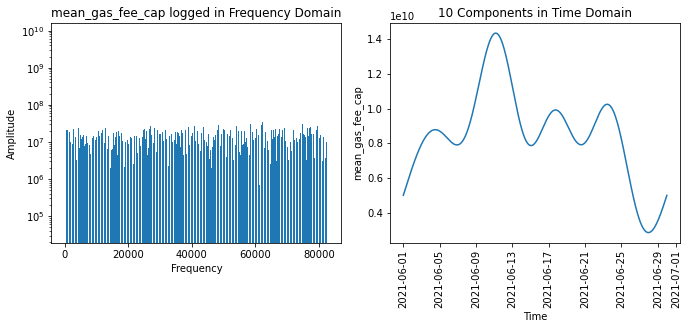

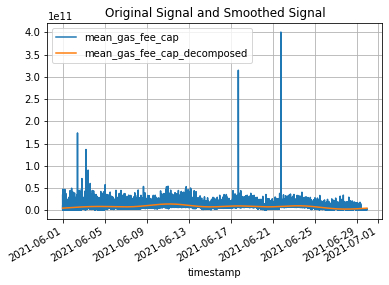

In [53]:
derived_gas_outputs_seconds, mean_gas_fee_cap_decomposed = fourier_transform(derived_gas_outputs_seconds,'mean_gas_fee_cap',10)

Fourier Transform of mean_gas_premium with 10 components.


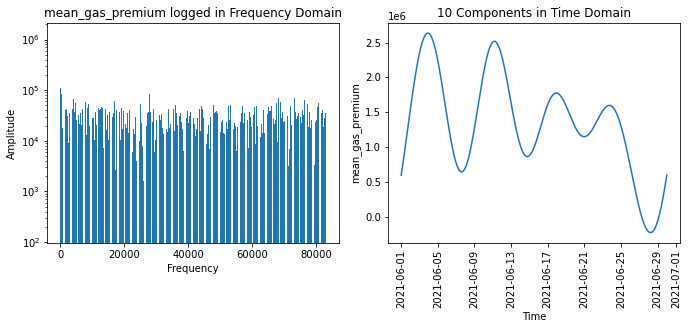

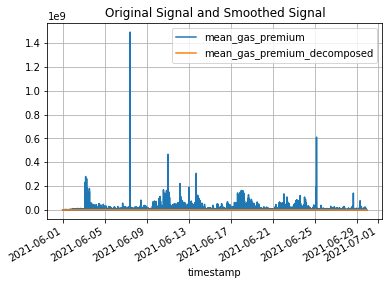

In [54]:
derived_gas_outputs_seconds, mean_gas_premium_decomposed  = fourier_transform(derived_gas_outputs_seconds,'mean_gas_premium',10)

Fourier Transform of mean_gas_limit with 10 components.


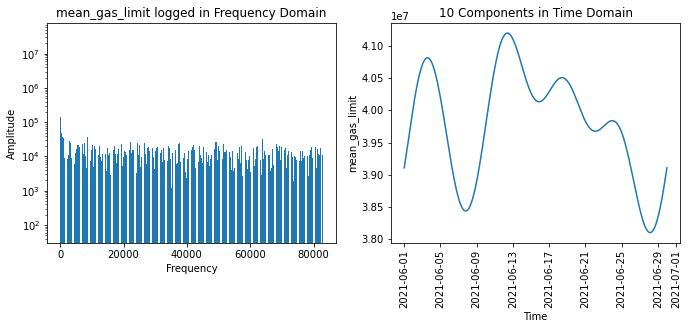

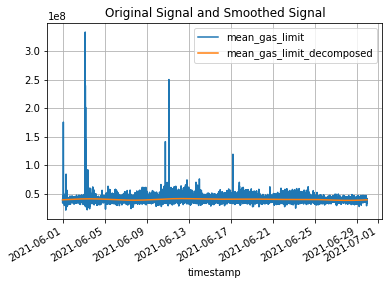

In [55]:
derived_gas_outputs_seconds, mean_gas_limit_decomposed = fourier_transform(derived_gas_outputs_seconds,'mean_gas_limit',10)

Fourier Transform of mean_gas_used with 10 components.


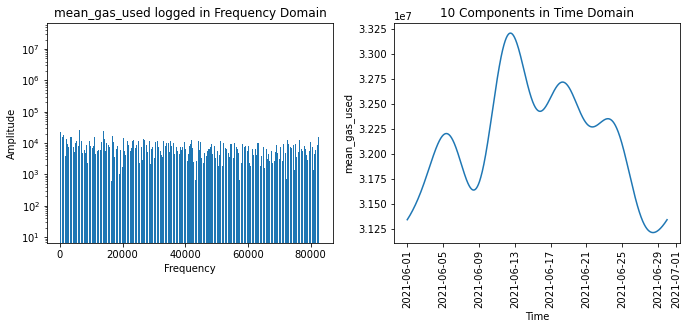

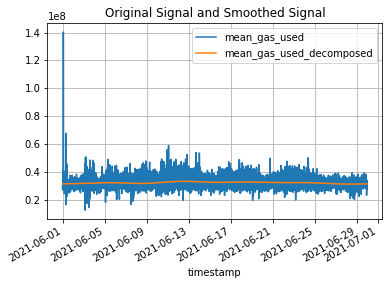

In [56]:
derived_gas_outputs_seconds, mean_gas_used_decomposed = fourier_transform(derived_gas_outputs_seconds,'mean_gas_used',10)

Fourier Transform of mean_parent_base_fee with 10 components.


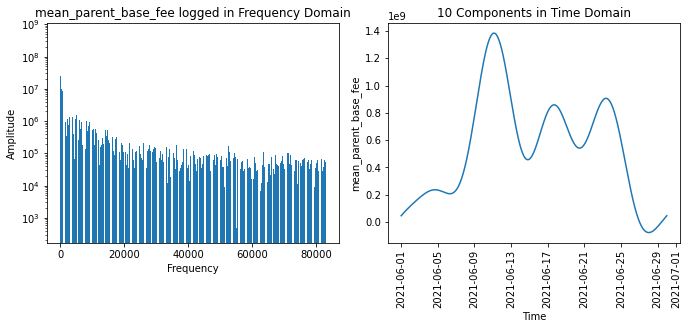

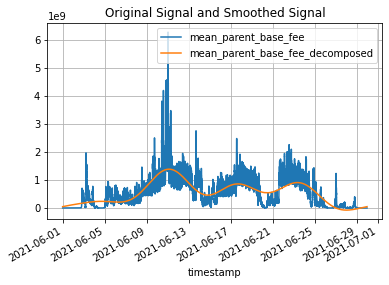

In [57]:
derived_gas_outputs_seconds, mean_parent_base_fee_decomposed = fourier_transform(derived_gas_outputs_seconds,'mean_parent_base_fee',10)

Fourier Transform of mean_base_fee_burn with 10 components.


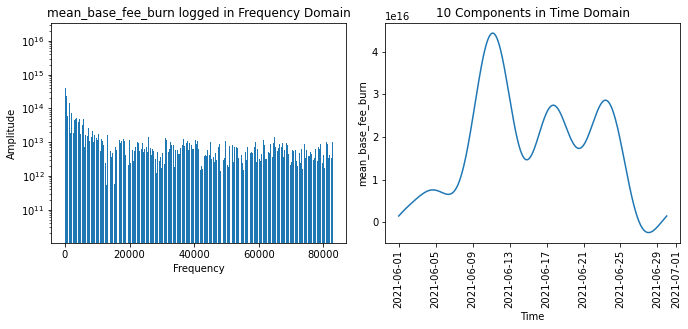

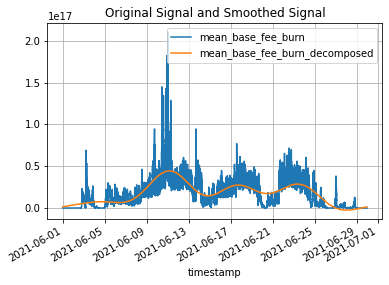

In [58]:
derived_gas_outputs_seconds, mean_base_fee_burn_decomposed = fourier_transform(derived_gas_outputs_seconds,'mean_base_fee_burn',10)

In [59]:
#derived_gas_outputs_seconds, mean_gas_burned_decomposed = fourier_transform(derived_gas_outputs_seconds,'mean_gas_burned',10)

Fourier Transform of mean_over_estimation_burn with 10 components.


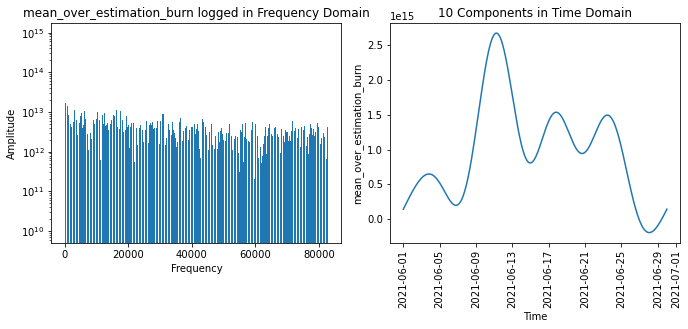

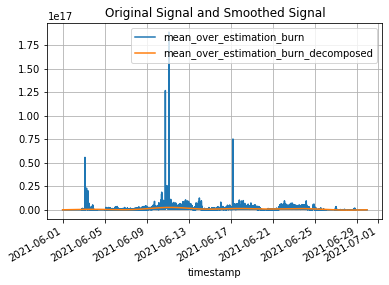

In [60]:
derived_gas_outputs_seconds, mean_over_estimation_burn_decomposed = fourier_transform(derived_gas_outputs_seconds,'mean_over_estimation_burn',10)

Fourier Transform of mean_gas_refund with 10 components.


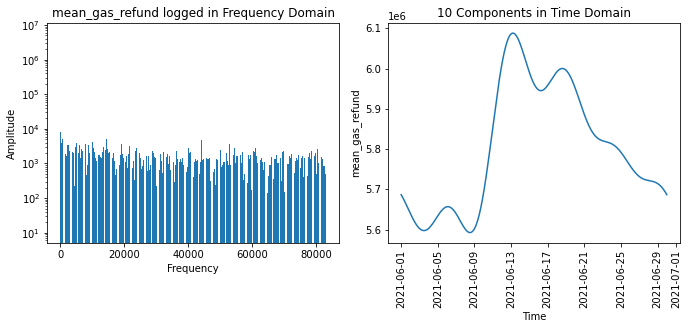

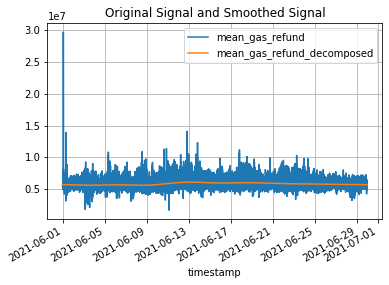

In [61]:
derived_gas_outputs_seconds, mean_gas_refund_decomposed = fourier_transform(derived_gas_outputs_seconds,'mean_gas_refund',10)

Fourier Transform of mean_message_cost with 10 components.


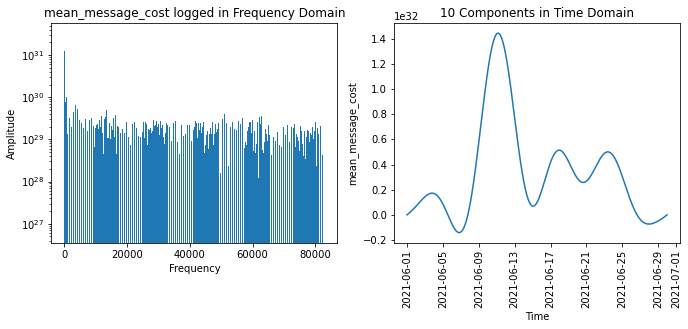

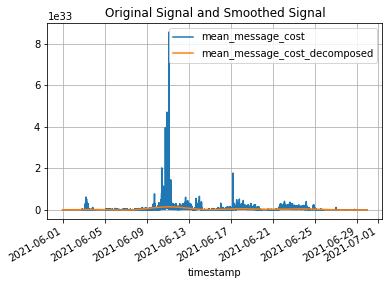

In [62]:
derived_gas_outputs_seconds, mean_message_cost_decomposed = fourier_transform(derived_gas_outputs_seconds,'mean_message_cost',10)

Based on the Fourier decompositions, it appears that there is some periodicity to the data, with two spikes a week, approximately on Monday and Thursday.

## Decomposed Phase Shifts Overlay  

To understand which signals may be leading or lagging indicators, we will overlay the fourier decomposed components, in pairs, for analysis.

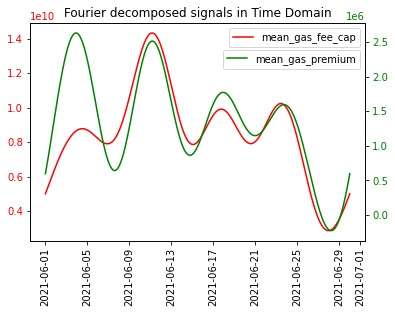

In [63]:
phase_shift_overlay(derived_gas_outputs_seconds.timestamp,mean_gas_fee_cap_decomposed,mean_gas_premium_decomposed,
                    'mean_gas_fee_cap','mean_gas_premium')

Gas premium appears to be a leading indicator for gas fee cap. There is no phase shift (peak to peak distances line up).

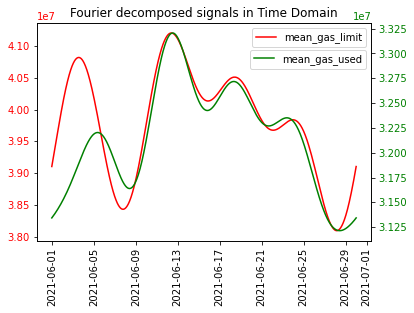

In [64]:
phase_shift_overlay(derived_gas_outputs_seconds.timestamp,mean_gas_limit_decomposed,mean_gas_used_decomposed,
                   'mean_gas_limit','mean_gas_used')

Gas limit, at times, appears to be a slight leading indicator.

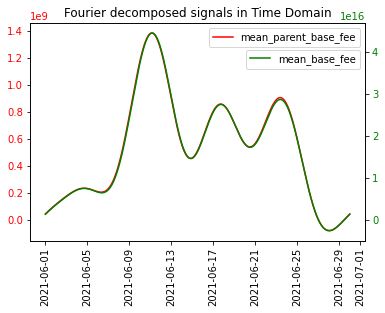

In [65]:
phase_shift_overlay(derived_gas_outputs_seconds.timestamp,mean_parent_base_fee_decomposed,mean_base_fee_burn_decomposed,
                   'mean_parent_base_fee','mean_base_fee')

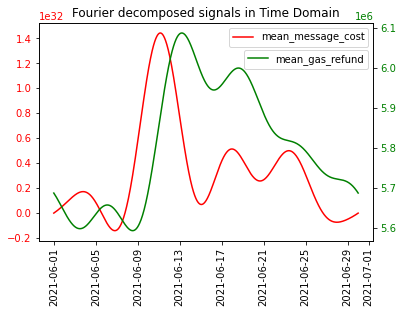

In [66]:
phase_shift_overlay(derived_gas_outputs_seconds.timestamp,mean_message_cost_decomposed,mean_gas_refund_decomposed,
                   'mean_message_cost','mean_gas_refund')

Message cost, at times, appears to be a slight leading indicator.

In [67]:
# phase_shift_overlay(derived_gas_outputs_seconds.timestamp,mean_gas_burned_decomposed,mean_gas_fee_cap_decomposed,
#                    'mean_gas_burned','mean_gas_fee_Cap')

<!-- Gas burned appears to be a direct leading indicator. No phase shift present
 -->
Below we will normalize the signals by their individual max peaks so we can plot on one graph. We will use Matplotlib instead of Plotly due to the fact that Matplotlib handles complex numbers better.

In [68]:
def peak_normalization(array):
    '''
    '''
    
    normalized = array / np.max(array)
    
    return normalized

# normalize peaks    
mean_gas_fee_cap_decomposed_normalized = peak_normalization(mean_gas_fee_cap_decomposed) 
mean_gas_premium_decomposed_normalized = peak_normalization(mean_gas_premium_decomposed) 
mean_gas_limit_decomposed_normalized = peak_normalization(mean_gas_limit_decomposed)
mean_gas_used_decomposed_normalized = peak_normalization(mean_gas_used_decomposed)
mean_base_fee_burn_decomposed_normalized = peak_normalization(mean_base_fee_burn_decomposed)
mean_message_cost_decomposed = peak_normalization(mean_message_cost_decomposed)
mean_gas_refund_decomposed = peak_normalization(mean_gas_refund_decomposed)
#mean_gas_burned_decomposed = peak_normalization(mean_gas_burned_decomposed)
mean_gas_fee_cap_decomposed = peak_normalization(mean_gas_fee_cap_decomposed)



Text(0.5, 1.0, 'Decomposed Phase Shifts Overlay, normalize by max peaks')

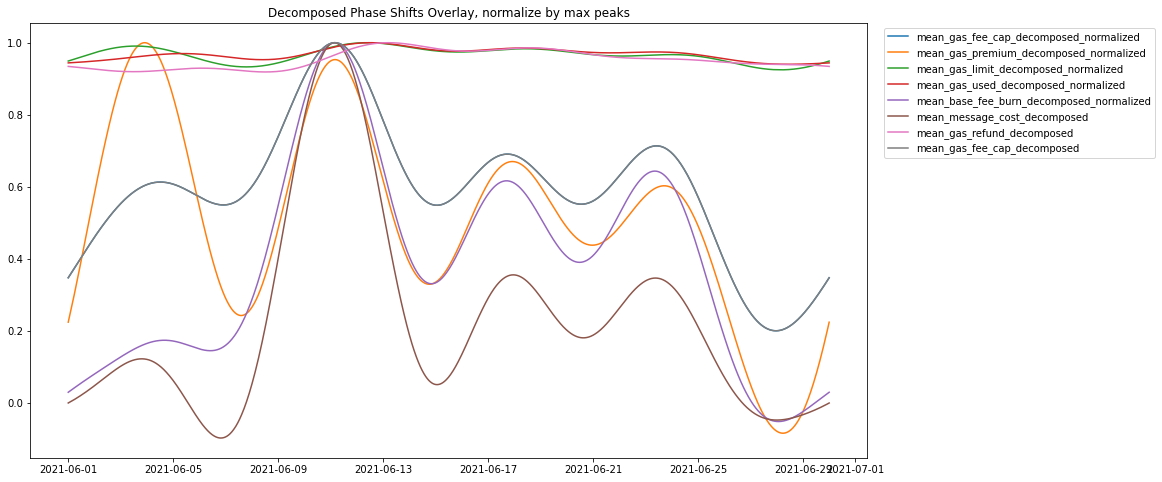

In [69]:
timestamps = derived_gas_outputs_seconds['timestamp'].values
plt.figure(figsize=(15, 8))
plt.plot(timestamps,mean_gas_fee_cap_decomposed_normalized,label = 'mean_gas_fee_cap_decomposed_normalized')
plt.plot(timestamps,mean_gas_premium_decomposed_normalized, label ='mean_gas_premium_decomposed_normalized')
plt.plot(timestamps,mean_gas_limit_decomposed_normalized, label ='mean_gas_limit_decomposed_normalized')
plt.plot(timestamps,mean_gas_used_decomposed_normalized, label ='mean_gas_used_decomposed_normalized')
plt.plot(timestamps,mean_base_fee_burn_decomposed_normalized, label ='mean_base_fee_burn_decomposed_normalized')
plt.plot(timestamps,mean_message_cost_decomposed, label ='mean_message_cost_decomposed')
plt.plot(timestamps,mean_gas_refund_decomposed, label ='mean_gas_refund_decomposed')
#plt.plot(timestamps,mean_gas_burned_decomposed, label ='mean_gas_burned_decomposed')
plt.plot(timestamps,mean_gas_fee_cap_decomposed, label ='mean_gas_fee_cap_decomposed')
plt.legend(bbox_to_anchor=(1.35, 1), loc='upper right', ncol=1)
plt.title('Decomposed Phase Shifts Overlay, normalize by max peaks')

### Data processing

We will now remove the timestamp field and examine the data distributions and determine if any transformations are required prior to our VAR modeling.

In [70]:
timestamps = combined.timestamp
del combined['timestamp']


array([[<AxesSubplot:title={'center':'mean_gas_fee_cap'}>,
        <AxesSubplot:title={'center':'mean_gas_premium'}>,
        <AxesSubplot:title={'center':'mean_gas_limit'}>,
        <AxesSubplot:title={'center':'mean_gas_used'}>,
        <AxesSubplot:title={'center':'mean_parent_base_fee'}>,
        <AxesSubplot:title={'center':'mean_base_fee_burn'}>],
       [<AxesSubplot:title={'center':'mean_over_estimation_burn'}>,
        <AxesSubplot:title={'center':'mean_gas_refund'}>,
        <AxesSubplot:title={'center':'mean_gas_burned'}>,
        <AxesSubplot:title={'center':'mean_message_cost'}>,
        <AxesSubplot:title={'center':'mean_cum_sum_baseline'}>,
        <AxesSubplot:title={'center':'mean_cum_sum_realized'}>],
       [<AxesSubplot:title={'center':'mean_effective_baseline_power'}>,
        <AxesSubplot:title={'center':'mean_effective_network_time'}>,
        <AxesSubplot:title={'center':'mean_new_baseline_power'}>,
        <AxesSubplot:title={'center':'mean_new_reward'}>,
     

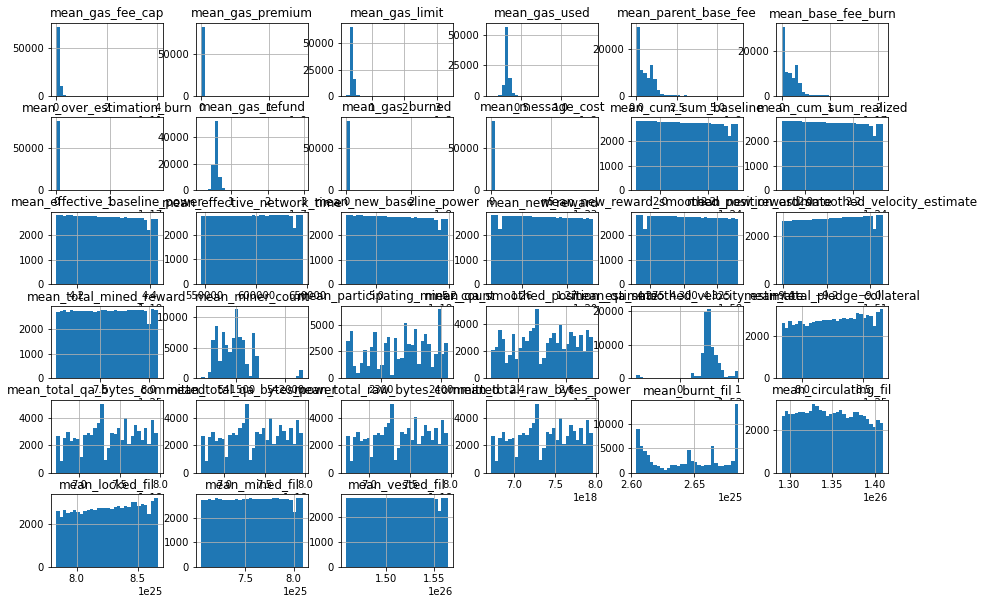

In [71]:
combined.hist(bins=30, figsize=(15, 10))

We can see from the above historgrams that our data is not normally distributed and will need to be transformed prior to modeling. We will take the log of the data to reduce the skewness and take the first difference to make the data stationary. 

In [72]:
np.random.seed(0)
log_differenced = pd.DataFrame()
## Difference and log values
for i in combined.columns:
    try:
        log_differenced[i +'_log_differenced'] = np.log(combined[i]).diff()
        log_differenced[i +'_log_differenced'].iat[0] = np.log(combined[i].iat[0])
    except:
        pass
# replace any NA values with zero
log_differenced.fillna(0,inplace=True)

In [73]:
#log_differenced.hist(bins=10, figsize=(25, 20))

The `derived_gas_outputs` data looks normally distributed, however the `chain_economics` and other chain signals are still non-normal. We will cautiously proceed.

As a final check prior to modeling, we will run the Augmented Dickey-Fuller test to ensure that our data is stationary (non-unit root - A unit root is a stochastic trend in a time series). The test's hypothesis are:


* $H_O: \textrm{Time series has a unit root}$
* $H_A: \textrm{Time series does not have a unit root}$

In [74]:
for i in log_differenced.columns:
    print(i)
    result = adfuller(log_differenced[i].values)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    if result[1] > 0.05:
        decision = "fail to reject - unit root present"
    else:
        decision = "reject, no unit root present"
    print(decision)
    print('----------------------------------')

mean_gas_fee_cap_log_differenced
ADF Statistic: -57.818818
p-value: 0.000000
reject, no unit root present
----------------------------------
mean_gas_premium_log_differenced
ADF Statistic: -52.834786
p-value: 0.000000
reject, no unit root present
----------------------------------
mean_gas_limit_log_differenced
ADF Statistic: -53.914586
p-value: 0.000000
reject, no unit root present
----------------------------------
mean_gas_used_log_differenced
ADF Statistic: -57.098622
p-value: 0.000000
reject, no unit root present
----------------------------------
mean_parent_base_fee_log_differenced
ADF Statistic: -60.529127
p-value: 0.000000
reject, no unit root present
----------------------------------
mean_base_fee_burn_log_differenced
ADF Statistic: -34.943983
p-value: 0.000000
reject, no unit root present
----------------------------------
mean_over_estimation_burn_log_differenced
ADF Statistic: -39.620263
p-value: 0.000000
reject, no unit root present
----------------------------------
mea

Based on the Augmented Dickey-Fuller, our preprocessing was successful and none of our univariate time series signals as a unit root. We can now proceed to the VAR model.

## Model Fit

To determine the ideal number of lags for our model, we will perform a heuristic SVD. We will fit our model with an autocorrelation between 1 and 15 to ascertain which VAR order has the best Akaike information criterion(AIC) score.

The **Akaike information criterion (AIC)** is an estimator of prediction error, rooted in information theory. Given a collection of models for the data, AIC estimates the quality of each model, relative to each of the other models as a means for model selection.

When a statistical model is used to represent the process that generated the data, the representation will rarely be exact; so some information will be lost by using the model to represent the process. AIC estimates the relative amount of information lost by a given model: the less information a model loses, the higher the quality of that model.

In estimating the amount of information lost by a model, AIC deals with the trade-off between the goodness of fit of the model and the simplicity of the model. In other words, AIC deals with both the risk of overfitting and the risk of underfitting.

Below is the equation for AIC where $\hat L$ is the maximum value of the likelihood function for the model: 

$$\mathrm{AIC} \, = \, 2k - 2\ln(\hat L)$$

Given a set of candidate models for the data, the **preferred model is the one with the minimum AIC value, the sign of the data does not matter**. AIC optimizes for the goodness of fit but also includes a penalty for each additional parameter, which discourages overfitting.

<!-- The **Bayesian information criterion (BIC)** is a statistical method for model selection among a group of models; **the model with the lowest BIC is preferred, the sign of the data does not matter**. It is based, in part, on the likelihood function and it is closely related to the Akaike information criterion (AIC).

When fitting models, it is possible to increase the likelihood by adding parameters, but doing so may result in overfitting. Both BIC and AIC attempt to resolve this problem by introducing a penalty term for the number of parameters in the model; the penalty term is larger in BIC than in AIC.

$$\mathrm{BIC} = k\ln(n) - 2\ln(\widehat L)$$
where
$\hat L$ = the maximized value of the likelihood function of the model $M$
$x$ = the observed data;
$n$ = the number of data points in $x$, 
$k$ = the number of parameters estimated by the model. 


Several researchers that have studied the two metrics argue that BIC is appropriate for selecting the "true model" (i.e. the process that generated the data) from the set of candidate models, whereas AIC choices the best model amongst the alternatives. Proponents of AIC argue that this issue is negligible because the "true model" is virtually never in the candidate set. For our use cases, we will optimize for the AIC as we know the "true" model of the signal behavior is way too complex to be captured within a VAR model.
 -->
Paraphrased sources:
* https://en.wikipedia.org/wiki/Akaike_information_criterion
<!-- * https://en.wikipedia.org/wiki/Bayesian_information_criterion -->

In [75]:
# removed several columns because of VAR errors - mean_mined_fil_log_differenced
log_differenced_subset = log_differenced[['mean_gas_fee_cap_log_differenced', 'mean_gas_premium_log_differenced',
                                         'mean_gas_limit_log_differenced','mean_gas_used_log_differenced',
                                         'mean_parent_base_fee_log_differenced','mean_base_fee_burn_log_differenced',
                                         'mean_over_estimation_burn_log_differenced','mean_gas_refund_log_differenced',
                                         'mean_cum_sum_baseline_log_differenced','mean_cum_sum_realized_log_differenced',
                                         'mean_effective_baseline_power_log_differenced','mean_effective_network_time_log_differenced',
                                         'mean_new_baseline_power_log_differenced','mean_new_reward_log_differenced',
                                         'mean_new_reward_smoothed_position_estimate_log_differenced','mean_total_mined_reward_log_differenced',
                                         'mean_miner_count_log_differenced','mean_participating_miner_count_log_differenced',
                                         'mean_qa_smoothed_position_estimate_log_differenced','mean_qa_smoothed_velocity_estimate_log_differenced',
                                         'mean_total_pledge_collateral_log_differenced','mean_total_qa_bytes_committed_log_differenced',
                                         'mean_total_qa_bytes_power_log_differenced','mean_total_raw_bytes_committed_log_differenced',
                                         'mean_total_raw_bytes_power_log_differenced','mean_burnt_fil_log_differenced','mean_circulating_fil_log_differenced',
                                         'mean_locked_fil_log_differenced','mean_vested_fil_log_differenced']]

In [76]:
aic = []
for i in range(1,16):
    model = VAR(log_differenced_subset)
    results = model.fit(i)
    aic.append(results.aic)

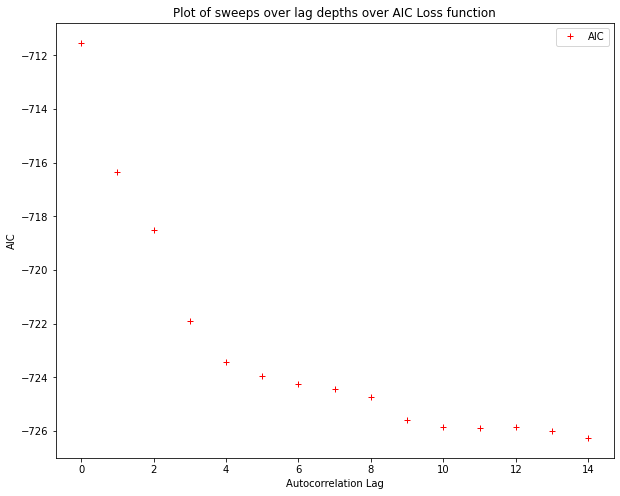

In [77]:
plt.figure(figsize=(10, 8))
plt.plot(aic, 'r+')
plt.legend(['AIC'])
plt.xlabel('Autocorrelation Lag')
plt.ylabel('AIC')
plt.title('Plot of sweeps over lag depths over AIC Loss function')
plt.show()

Based on our analysis, a lag of 10 appears to be the optimal.

In [78]:
# instantiate the var model object from statsmodels
model = VAR(log_differenced_subset)

# fit model with determined lag values
results = model.fit(10)

In [79]:
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 08, Aug, 2021
Time:                     17:21:08
--------------------------------------------------------------------
No. of Equations:         29.0000    BIC:                   -724.632
Nobs:                     82934.0    HQIC:                  -725.290
Log likelihood:       2.66834e+07    FPE:               7.65980e-316
AIC:                     -725.581    Det(Omega_mle):    6.91995e-316
--------------------------------------------------------------------
Results for equation mean_gas_fee_cap_log_differenced
                                                                       coefficient        std. error           t-stat            prob
-------------------------------------------------------------------------------------------------------------------------------------
const                                                                     0.003296       

## Granger causality

Granger causality is a hypothesis test for determining whether one-time series is useful in forecasting another. We can say that a variable X, or variables, evolves Granger-causes another evolving variable Y if predictions of the value of Y based on its past values and the past values of X are better than predictions of Y based only on Y's past values. 

Granger Causality is relationship based on the following principles:

* The cause happens before its effect.
* The cause has 'unique' information about the future values of its effect.


Given these two assumptions about causality, Granger proposed to test the following hypothesis for identification of a causal effect of $X$ on $Y$:
$${P}[Y(t+1) \in A\mid \mathcal{I}(t)] \neq \mathbb{P}[Y(t+1) \in A\mid \mathcal{I}_{-X}(t)]$$
where $\mathbb{P}$ refers to probability, $A$ is an arbitrary non-empty set, and $\mathcal{I}(t)$ and $\mathcal{I}_{-X}(t)$ respectively denote the information available as of time $t$ in the entire universe, and that in the modified universe in which $X$ is excluded. If the above hypothesis is accepted, we say that $X$ Granger causes $Y$.

In our analysis, we present the hypothesis that gas_used is a driver of message cost. In statistical parlance, we have the following:

* $H_O: \textrm{Gas used does not Granger cause message cost}$
* $H_A: \textrm{Gas used does Granger cause message cost}$


Granger Causality assumes that the time series are non-stationary, which we checked and passed above, and autoregressive lags greater than 1.

We will perform now perform the Granger Causality hypothesis test with an $\alpha = 0.05$ value using an F test to determine if the gas used has any casual component for predicting the message cost. If the p-value (the probability of obtaining test results at least as extreme as the results observed) of the test is less than or equal to $\alpha$ we will reject the null hypothesis and determine that gas used is a driver of message cost.

### Paraphrased source:
* https://en.wikipedia.org/wiki/Granger_causality

As we have many signals with the analysis, we will loop through all the signals, perform the Granger Causality test, and save the results for analysis.

In [80]:
alpha = 0.05
result_dfs = []
variables = list(log_differenced_subset.columns)
for i in variables:
    for j in variables:
        if i==j:
            pass
        else:
            results_summary = results.test_causality(i,j, 
                                                     kind='f',signif=alpha).summary()


            df = pd.read_html(results_summary.as_html(),header=0, index_col=0)[0]
            df['alpha'] = alpha
            df['caused'] = i
            df['causing'] = j
            result_dfs.append(df)
        
Grangers_df = pd.concat(result_dfs)
Grangers_df.reset_index(inplace=True)
Grangers_df['result'] = Grangers_df['p-value'].apply(lambda x: 'reject H0' if x < alpha else 'fail to reject H0' )
Grangers_df




,Test statistic,Critical value,p-value,df,alpha,caused,causing,result
0,0.7600,1.831,0.668,"(10, 2396647)",0.05,mean_gas_fee_cap_log_differenced,mean_gas_premium_log_differenced,fail to reject H0
1,1.1340,1.831,0.332,"(10, 2396647)",0.05,mean_gas_fee_cap_log_differenced,mean_gas_limit_log_differenced,fail to reject H0
2,7.8730,1.831,0.000,"(10, 2396647)",0.05,mean_gas_fee_cap_log_differenced,mean_gas_used_log_differenced,reject H0
3,27.9100,1.831,0.000,"(10, 2396647)",0.05,mean_gas_fee_cap_log_differenced,mean_parent_base_fee_log_differenced,reject H0
4,11.9400,1.831,0.000,"(10, 2396647)",0.05,mean_gas_fee_cap_log_differenced,mean_base_fee_burn_log_differenced,reject H0
...,...,...,...,...,...,...,...,...
807,0.1598,1.831,0.999,"(10, 2396647)",0.05,mean_vested_fil_log_differenced,mean_total_raw_bytes_committed_log_differenced,fail to reject H0
808,0.1700,1.831,0.998,"(10, 2396647)",0.05,mean_vested_fil_log_differenced,mean_total_raw_bytes_power_log_differenced,fail to reject H0
809,4.5280,1.831,0.000,"(10, 2396647)",0.05,mean_vested_fil_log_differenced,mean_burnt_fil_log_differenced,reject H0
810,4.9560,1.831,0.000,"(10, 2396647)",0.05,mean_vested_fil_log_differenced,mean_circulating_fil_log_differenced,reject H0


Text(0.5, 0.98, 'Heatmap of Granger Casuality \n Green shows causal relationship whereas red shows no causal relationship')

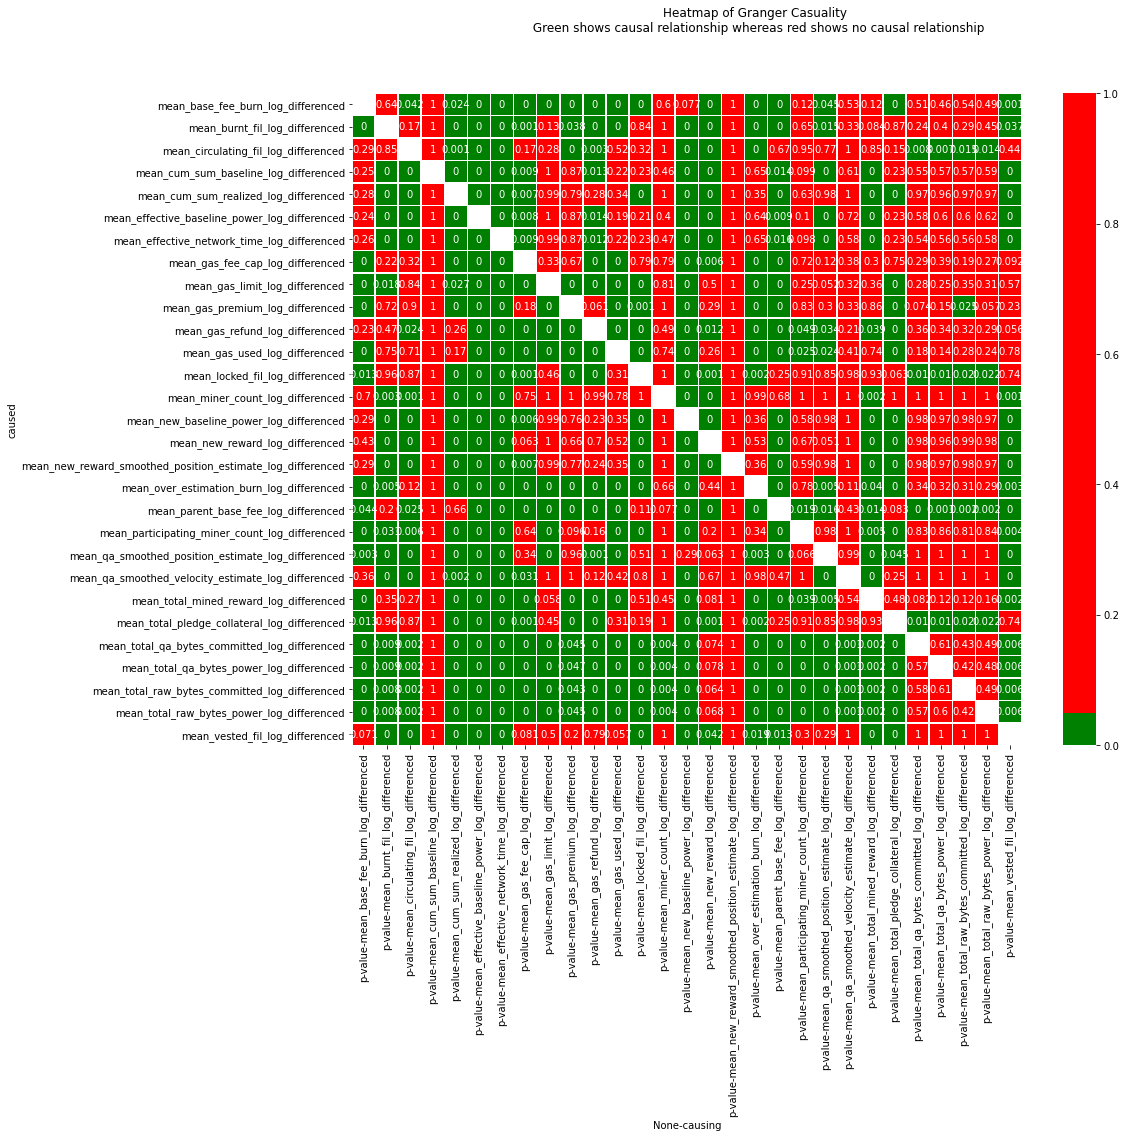

In [81]:
heatdf = Grangers_df.pivot(index='caused', columns=['causing'],values=['p-value'])

f, ax = plt.subplots(figsize=(15, 12))
sns.heatmap(heatdf, annot=True, linewidths=.5, ax=ax,cmap=['green','red'],center=0.05)
plt.suptitle('Heatmap of Granger Casuality \n Green shows causal relationship whereas red shows no causal relationship')




Based on the heatmap above, we can see that there are some granger causal relationships between signals. To see more granular specifics, we will examine the reject H0s below

In [82]:
Grangers_df.query("result == 'reject H0'").sort_values('p-value',ascending=True)

,Test statistic,Critical value,p-value,df,alpha,caused,causing,result
2,7.873,1.831,0.000,"(10, 2396647)",0.05,mean_gas_fee_cap_log_differenced,mean_gas_used_log_differenced,reject H0
514,322.900,1.831,0.000,"(10, 2396647)",0.05,mean_qa_smoothed_position_estimate_log_differe...,mean_effective_baseline_power_log_differenced,reject H0
513,4.535,1.831,0.000,"(10, 2396647)",0.05,mean_qa_smoothed_position_estimate_log_differe...,mean_cum_sum_realized_log_differenced,reject H0
508,3.607,1.831,0.000,"(10, 2396647)",0.05,mean_qa_smoothed_position_estimate_log_differe...,mean_parent_base_fee_log_differenced,reject H0
507,5.052,1.831,0.000,"(10, 2396647)",0.05,mean_qa_smoothed_position_estimate_log_differe...,mean_gas_used_log_differenced,reject H0
...,...,...,...,...,...,...,...,...
523,1.867,1.831,0.045,"(10, 2396647)",0.05,mean_qa_smoothed_position_estimate_log_differe...,mean_total_pledge_collateral_log_differenced,reject H0
673,1.865,1.831,0.045,"(10, 2396647)",0.05,mean_total_raw_bytes_power_log_differenced,mean_gas_premium_log_differenced,reject H0
157,1.862,1.831,0.045,"(10, 2396647)",0.05,mean_base_fee_burn_log_differenced,mean_qa_smoothed_position_estimate_log_differe...,reject H0
617,1.849,1.831,0.047,"(10, 2396647)",0.05,mean_total_qa_bytes_power_log_differenced,mean_gas_premium_log_differenced,reject H0


Based on the above table, we can see some Granger caused relationships between signals, such as mean_gas_fee_cap Granger causes mean_gas_limit. We can't fully use Granger until we understand what the signals are and what they represent better.

## Conclusion

## Behavior Model

For our Digital Twin of the Filecoin system, we need to construct a behavior model to forecast daily values. Very rough V1.

In [83]:
QUERY = """
SELECT 
date_trunc('day', 
to_timestamp(height_to_unix(d.height))) AS timestamp,
AVG(CAST(gas_fee_cap AS FLOAT)) AS mean_gas_fee_cap,
AVG(CAST(gas_premium AS FLOAT))  as mean_gas_premium,
AVG(CAST(gas_limit AS FLOAT))  as mean_gas_limit,
AVG(CAST(gas_used AS FLOAT))  as mean_gas_used,
AVG(CAST(parent_base_fee AS FLOAT))  as mean_parent_base_fee,
AVG(CAST(base_fee_burn AS FLOAT))  as mean_base_fee_burn,
AVG(CAST(over_estimation_burn AS FLOAT))  as mean_over_estimation_burn,
AVG(CAST(gas_refund AS FLOAT))  as mean_gas_refund,
AVG(CAST(gas_burned AS FLOAT))  as mean_gas_burned
FROM derived_gas_outputs d
WHERE
to_timestamp(height_to_unix(d.height)) BETWEEN '2021-01-01' AND '2021-07-28'
GROUP BY
timestamp
"""
derived_gas_outputs_day = (pd.read_sql(QUERY, connection))

In [84]:
QUERY = """
SELECT 
date_trunc('day', 
to_timestamp(height_to_unix(cr.height))) AS timestamp,
AVG(CAST(cr.cum_sum_baseline AS FLOAT)) AS mean_cum_sum_baseline,
AVG(CAST(cr.cum_sum_realized AS FLOAT)) AS mean_cum_sum_realized,
AVG(CAST(cr.effective_baseline_power AS FLOAT)) AS mean_effective_baseline_power,
AVG(CAST(cr.effective_network_time AS FLOAT)) AS mean_effective_network_time,
AVG(CAST(cr.new_baseline_power AS FLOAT)) AS mean_new_baseline_power,
AVG(CAST(cr.new_reward AS FLOAT)) AS mean_new_reward,
AVG(CAST(cr.new_reward_smoothed_position_estimate AS FLOAT)) AS mean_new_reward_smoothed_position_estimate,
AVG(CAST(cr.new_reward_smoothed_velocity_estimate AS FLOAT)) AS mean_new_reward_smoothed_velocity_estimate,
AVG(CAST(cr.total_mined_reward AS FLOAT)) AS mean_total_mined_reward,
AVG(CAST(cp.miner_count AS FLOAT)) AS mean_miner_count,
AVG(CAST(cp.participating_miner_count AS FLOAT)) AS mean_participating_miner_count,
AVG(CAST(cp.qa_smoothed_position_estimate AS FLOAT)) AS mean_qa_smoothed_position_estimate,
AVG(CAST(cp.qa_smoothed_velocity_estimate AS FLOAT)) AS mean_qa_smoothed_velocity_estimate,
AVG(CAST(cp.total_pledge_collateral AS FLOAT)) AS mean_total_pledge_collateral,
AVG(CAST(cp.total_qa_bytes_committed AS FLOAT)) AS mean_total_qa_bytes_committed,
AVG(CAST(cp.total_qa_bytes_power AS FLOAT)) AS mean_total_qa_bytes_power,
AVG(CAST(cp.total_raw_bytes_committed AS FLOAT)) AS mean_total_raw_bytes_committed,
AVG(CAST(cp.total_raw_bytes_power AS FLOAT)) AS mean_total_raw_bytes_power,
AVG(CAST(ce.burnt_fil AS FLOAT)) AS mean_burnt_fil,
AVG(CAST(ce.circulating_fil AS FLOAT)) AS mean_circulating_fil,
AVG(CAST(ce.locked_fil AS FLOAT)) AS mean_locked_fil,
AVG(CAST(ce.mined_fil AS FLOAT)) AS mean_mined_fil,
AVG(CAST(ce.vested_fil AS FLOAT)) AS mean_vested_fil
FROM chain_rewards cr
LEFT JOIN chain_powers cp
ON cr.state_root = cp.state_root
LEFT JOIN chain_economics ce
ON cr.state_root = ce.parent_state_root
WHERE
to_timestamp(height_to_unix(cr.height)) BETWEEN '2021-01-01' AND '2021-07-28'
GROUP BY
timestamp
"""
chain_economics_day = (pd.read_sql(QUERY, connection))



In [85]:
pd.set_option('display.float_format', lambda x: '%.5f' % x)



In [86]:
# combine signals
combined_day = derived_gas_outputs_day.merge(chain_economics_day,how='left',on='timestamp')
combined_day.describe()

,mean_gas_fee_cap,mean_gas_premium,mean_gas_limit,mean_gas_used,mean_parent_base_fee,mean_base_fee_burn,mean_over_estimation_burn,mean_gas_refund,mean_gas_burned,mean_cum_sum_baseline,...,mean_total_pledge_collateral,mean_total_qa_bytes_committed,mean_total_qa_bytes_power,mean_total_raw_bytes_committed,mean_total_raw_bytes_power,mean_burnt_fil,mean_circulating_fil,mean_locked_fil,mean_mined_fil,mean_vested_fil
count,59.00000,59.00000,59.00000,59.00000,59.00000,59.00000,59.00000,59.00000,59.00000,58.00000,...,58.00000,58.00000,58.00000,58.00000,58.00000,58.00000,58.00000,58.00000,58.00000,58.00000
mean,5513764599.27083,779567.86457,42796538.21884,34785567.76599,324497584.52827,10702441437204534.00000,574911659488441.37500,6236081.25181,1774889.20104,2327819556277354418405376.00000,...,86821733576156714413064192.00000,8018422700315113472.00000,8017973781821206528.00000,8015668284604048384.00000,8015229091141893120.00000,26715685944095650441330688.00000,140782685485476985454985216.00000,86831343052147401152266240.00000,80869563268025732661510144.00000,156393532251920925645078528.00000
std,3684484772.96469,870938.96647,3602577.13853,2973285.20602,364251457.33417,11517642841690734.00000,666689380078859.00000,508835.99344,434658.19433,252554170584497741889536.00000,...,4979964280915171907469312.00000,764412148993668224.00000,764409584587406464.00000,763884555966834688.00000,763878423698116480.00000,343194487670754307473408.00000,6827838961405845630353408.00000,4980518631971240917598208.00000,5966288740640559693037568.00000,6159324709164489736454144.00000
min,1435953211.88763,100750.11059,37277468.82593,30214119.92849,102.90795,3120658409.62568,171439423.16412,5480787.27241,1319441.62411,1908857373855164437364736.00000,...,78458853397837202401001472.00000,6755098031297469440.00000,6754589830064668672.00000,6752989031858666496.00000,6752497531198137344.00000,26041012965313313660469248.00000,129281449575053806564016128.00000,78467087855590290074107904.00000,70730120556838973807263744.00000,145992810877345019094630400.00000
25%,2518722674.45341,245250.55322,39492829.37820,32184388.22712,126920875.02017,4319455509135297.00000,209884231122116.68750,5754182.12158,1550820.24453,2113606728848292651728896.00000,...,82749400220976928648069120.00000,7403331097903878144.00000,7402935466629068800.00000,7400994986570546176.00000,7400614135808150528.00000,26475501575103452383543296.00000,134870374020500757663449088.00000,82758528548923432079720448.00000,75843116551862116899880960.00000,151194668630892086355296256.00000
50%,2820050774.36324,340598.82305,41983029.37938,33377061.44188,157547108.47885,5834867675979685.00000,263696901668051.00000,6090883.33983,1693245.31151,2323978528983291502002176.00000,...,86604157442057537553694720.00000,7943631143157460992.00000,7943201918081957888.00000,7941000364339126272.00000,7940585443748105216.00000,26850147131516598779641856.00000,140906713427771170054209536.00000,86614260680302555840905216.00000,80907780830561943569825792.00000,156396721447254886398820352.00000
75%,8779641266.38295,992241.97860,46409521.25946,37704892.72420,393457302.14625,12611152216044808.00000,776976050677631.50000,6724390.74650,1803421.51694,2540120339522715685748736.00000,...,90934286232874802506366976.00000,8646171788466956288.00000,8645719248644027392.00000,8643025059546769408.00000,8642577749019783168.00000,26959393679700627975831552.00000,146684769814511451549728768.00000,90944395121881435986722816.00000,85923136653312693561720832.00000,161598803001007434618634240.00000
max,13948241946.82050,4876887.81949,49142218.09421,39685622.85690,1448219388.20665,45827824053143104.00000,2667938987872242.00000,7131652.03176,4047044.35432,2754293985595333294424064.00000,...,95484730224346023396900864.00000,9433791232083787776.00000,9433339819393220608.00000,9429896089038749696.00000,9429447350855663616.00000,27141664085021777725489152.00000,151762749972865654944956416.00000,95494718508828444227272704.00000,90714172733606828282216448.00000,166618

In [87]:
# split into train and test
combined_day_test = combined_day.tail(10)
combined_day = combined_day.head(len(combined_day)-10)

del combined_day['timestamp']
combined_day.fillna(0,inplace=True)

array([[<AxesSubplot:title={'center':'mean_gas_fee_cap'}>,
        <AxesSubplot:title={'center':'mean_gas_premium'}>,
        <AxesSubplot:title={'center':'mean_gas_limit'}>,
        <AxesSubplot:title={'center':'mean_gas_used'}>,
        <AxesSubplot:title={'center':'mean_parent_base_fee'}>,
        <AxesSubplot:title={'center':'mean_base_fee_burn'}>],
       [<AxesSubplot:title={'center':'mean_over_estimation_burn'}>,
        <AxesSubplot:title={'center':'mean_gas_refund'}>,
        <AxesSubplot:title={'center':'mean_gas_burned'}>,
        <AxesSubplot:title={'center':'mean_cum_sum_baseline'}>,
        <AxesSubplot:title={'center':'mean_cum_sum_realized'}>,
        <AxesSubplot:title={'center':'mean_effective_baseline_power'}>],
       [<AxesSubplot:title={'center':'mean_effective_network_time'}>,
        <AxesSubplot:title={'center':'mean_new_baseline_power'}>,
        <AxesSubplot:title={'center':'mean_new_reward'}>,
        <AxesSubplot:title={'center':'mean_new_reward_smoothed_po

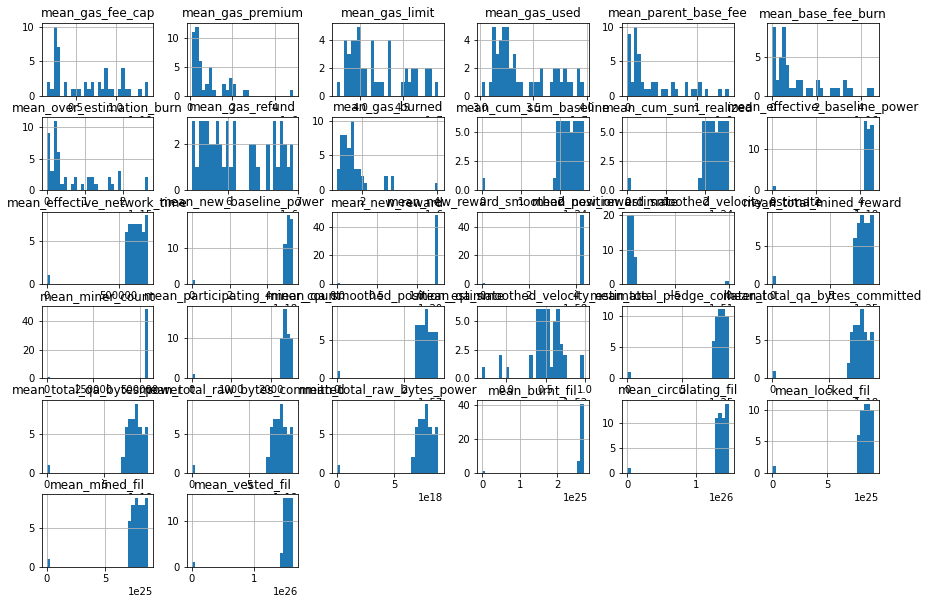

In [88]:
combined_day.hist(bins=30, figsize=(15, 10))

In [89]:
# from sklearn.preprocessing import PowerTransformer
# pt = PowerTransformer(standardize=False)
# yeo = pt.fit_transform(combined_day)
# yeo_df = pd.DataFrame(yeo,columns=combined_day.columns)
# yeo_df_stochastic.fillna(0,inplace=True)
# yeo_df.hist(bins=30, figsize=(15, 15))

In [90]:
np.random.seed(0)
log_differenced_day = pd.DataFrame()
## Difference and log values
for i in combined_day.columns:
    try:
        log_differenced_day[i +'_log_differenced'] = np.log(combined_day[i]).diff()
        log_differenced_day[i +'_log_differenced'].iat[0] = np.log(combined_day[i].iat[0])
    except:
        pass
# replace any NA values with zero
log_differenced_day.fillna(0,inplace=True)

In [91]:
# log_differenced_day.hist(bins=30, figsize=(15, 15))

# Behavior next steps
* Bag of records. Bootstrap sample for v1. 
* Eventually split into static and non-static. Non-static VAR and static boostrap


Based on the histograms above, we have some stochastic signals, such as *mean_base_fee_burn_log_differenced* and some close to constant values, such as *mean_vested_fil_log_differenced*. We will divide the dataset into two groups, stochastic and constants (some of which are not, but are highly skewed), and perform different manipulations on each to create a behavior model.

In [92]:
# yeo_df_stochastic = yeo_df[['mean_parent_base_fee','mean_gas_limit']]#,'mean_participating_miner_count','mean_qa_smoothed_velocity_estimate']]
# yeo_df_constant = yeo_df[yeo_df.columns[~yeo_df.columns.isin(['mean_parent_base_fee','mean_gas_limit'])]]

In [93]:
log_differenced_day_stochastic = log_differenced_day[['mean_parent_base_fee_log_differenced','mean_base_fee_burn_log_differenced',
                                                     ]]

log_differenced_day_constant = log_differenced_day[['mean_gas_fee_cap_log_differenced','mean_gas_premium_log_differenced',
                                                   'mean_gas_limit_log_differenced','mean_gas_used_log_differenced',
                                                   'mean_over_estimation_burn_log_differenced','mean_gas_refund_log_differenced',
                                                   'mean_gas_burned_log_differenced','mean_cum_sum_baseline_log_differenced',
                                                   'mean_cum_sum_realized_log_differenced','mean_effective_baseline_power_log_differenced',
                                                   'mean_effective_network_time_log_differenced','mean_new_baseline_power_log_differenced',
                                                   'mean_new_reward_log_differenced','mean_new_reward_smoothed_position_estimate_log_differenced',
                                                   'mean_new_reward_smoothed_velocity_estimate_log_differenced','mean_total_mined_reward_log_differenced',
                                                   'mean_miner_count_log_differenced','mean_participating_miner_count_log_differenced',
                                                   'mean_qa_smoothed_position_estimate_log_differenced','mean_qa_smoothed_velocity_estimate_log_differenced',
                                                   'mean_total_pledge_collateral_log_differenced','mean_total_qa_bytes_committed_log_differenced',
                                                   'mean_total_qa_bytes_power_log_differenced','mean_total_raw_bytes_committed_log_differenced',
                                                   'mean_total_raw_bytes_power_log_differenced','mean_burnt_fil_log_differenced',
                                                   'mean_circulating_fil_log_differenced','mean_locked_fil_log_differenced',
                                                   'mean_mined_fil_log_differenced','mean_vested_fil_log_differenced']]

<!-- ## Stochastic Signal Component Model -->

In [94]:
aic = []
for i in range(1,16):
    model = VAR(log_differenced_day_stochastic)
    results = model.fit(i)
    aic.append(results.aic)

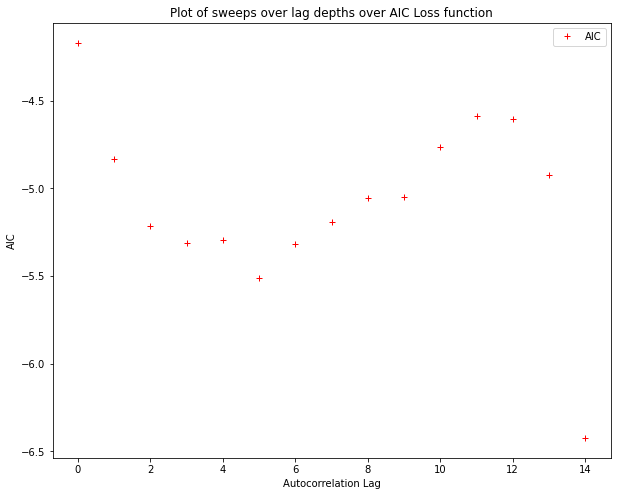

In [95]:
plt.figure(figsize=(10, 8))
plt.plot(aic, 'r+')
plt.legend(['AIC'])
plt.xlabel('Autocorrelation Lag')
plt.ylabel('AIC')
plt.title('Plot of sweeps over lag depths over AIC Loss function')
plt.show()

In [96]:
# instantiate the var model object from statsmodels
model = VAR(log_differenced_day_stochastic)

# fit model with determined lag values
results = model.fit(5)

In [97]:
# results.summary()

<!-- ## Constant Signal Component Model -->

In [100]:
log_differenced_day_constant_ewm = log_differenced_day_constant.ewm(alpha=0.5).mean()

In [102]:
log_differenced_day_constant_ewm_forcast=log_differenced_day_constant_ewm.tail(5)
log_differenced_day_constant_ewm_forcast.reset_index(inplace=True)
del log_differenced_day_constant_ewm_forcast['index']
log_differenced_day_constant_ewm_forcast

# yeo_df_constant_ewm_forcast=yeo_df_constant_ewm.tail(steps)
# yeo_df_constant_ewm_forcast.reset_index(inplace=True)
# del yeo_df_constant_ewm_forcast['index']

,mean_gas_fee_cap_log_differenced,mean_gas_premium_log_differenced,mean_gas_limit_log_differenced,mean_gas_used_log_differenced,mean_over_estimation_burn_log_differenced,mean_gas_refund_log_differenced,mean_gas_burned_log_differenced,mean_cum_sum_baseline_log_differenced,mean_cum_sum_realized_log_differenced,mean_effective_baseline_power_log_differenced,...,mean_total_pledge_collateral_log_differenced,mean_total_qa_bytes_committed_log_differenced,mean_total_qa_bytes_power_log_differenced,mean_total_raw_bytes_committed_log_differenced,mean_total_raw_bytes_power_log_differenced,mean_burnt_fil_log_differenced,mean_circulating_fil_log_differenced,mean_locked_fil_log_differenced,mean_mined_fil_log_differenced,mean_vested_fil_log_differenced
0,0.03258,0.06351,0.00361,0.00352,0.08334,0.00704,-0.00784,0.00609,0.00609,0.00222,...,0.00375,0.00715,0.00715,0.00714,0.00714,0.00042,0.00249,0.00375,0.00410,0.00227
1,0.00606,0.07646,0.01324,0.01261,0.13901,0.00815,0.04789,0.00606,0.00606,0.00222,...,0.00379,0.00697,0.00697,0.00696,0.00696,0.00048,0.00244,0.00379,0.00408,0.00226
2,-0.04047,-0.04822,0.00539,0.00571,-0.01965,0.00400,0.00428,0.00603,0.00603,0.00222,...,0.00381,0.00544,0.00544,0.00543,0.00543,0.00052,0.00240,0.00381,0.00405,0.00226
3,-0.04809,-0.11437,0.01869,0.01938,-0.05986,0.01439,0.02060,0.00601,0.00601,0.00222,...,0.00371,0.00104,0.00104,0.00103,0.00103,0.00073,0.00239,0.00371,0.00401,0.00225
4,-0.02517,-0.04691,0.01200,0.01205,-0.03420,0.00748,0.02857,0.00598,0.00598,0.00222,...,0.00369,0.00994,0.00994,0.00994,0.00994,0.00058,0.00243,0.00369,0.00401,0.00225


In [103]:
lag_order = results.k_ar
steps = 5

five_step_forecast_stochastic = results.forecast(log_differenced_day_stochastic.values[-lag_order:], steps)

In [ ]:
# five_step_forecast_df

In [105]:
five_step_forecast_df = pd.DataFrame(five_step_forecast_stochastic,columns=log_differenced_day_stochastic.columns)
five_step_forecast_df = pd.concat([five_step_forecast_df,log_differenced_day_constant_ewm_forcast],axis=1)
five_step_forecast_df

,mean_parent_base_fee_log_differenced,mean_base_fee_burn_log_differenced,mean_gas_fee_cap_log_differenced,mean_gas_premium_log_differenced,mean_gas_limit_log_differenced,mean_gas_used_log_differenced,mean_over_estimation_burn_log_differenced,mean_gas_refund_log_differenced,mean_gas_burned_log_differenced,mean_cum_sum_baseline_log_differenced,...,mean_total_pledge_collateral_log_differenced,mean_total_qa_bytes_committed_log_differenced,mean_total_qa_bytes_power_log_differenced,mean_total_raw_bytes_committed_log_differenced,mean_total_raw_bytes_power_log_differenced,mean_burnt_fil_log_differenced,mean_circulating_fil_log_differenced,mean_locked_fil_log_differenced,mean_mined_fil_log_differenced,mean_vested_fil_log_differenced
0,0.53759,0.55238,0.03258,0.06351,0.00361,0.00352,0.08334,0.00704,-0.00784,0.00609,...,0.00375,0.00715,0.00715,0.00714,0.00714,0.00042,0.00249,0.00375,0.00410,0.00227
1,0.49470,0.50202,0.00606,0.07646,0.01324,0.01261,0.13901,0.00815,0.04789,0.00606,...,0.00379,0.00697,0.00697,0.00696,0.00696,0.00048,0.00244,0.00379,0.00408,0.00226
2,0.46688,0.46160,-0.04047,-0.04822,0.00539,0.00571,-0.01965,0.00400,0.00428,0.00603,...,0.00381,0.00544,0.00544,0.00543,0.00543,0.00052,0.00240,0.00381,0.00405,0.00226
3,-0.13681,-0.13645,-0.04809,-0.11437,0.01869,0.01938,-0.05986,0.01439,0.02060,0.00601,...,0.00371,0.00104,0.00104,0.00103,0.00103,0.00073,0.00239,0.00371,0.00401,0.00225
4,-0.36765,-0.36348,-0.02517,-0.04691,0.01200,0.01205,-0.03420,0.00748,0.02857,0.00598,...,0.00369,0.00994,0.00994,0.00994,0.00994,0.00058,0.00243,0.00369,0.00401,0.00225


In [106]:
np.random.seed(0)
five_step_forecast_inversed = pd.DataFrame()
## Difference and log values
for i in five_step_forecast_df.columns:
    try:
        five_step_forecast_inversed[i.replace('_log_differenced','')] = np.exp(five_step_forecast_df[i].cumsum())
    except:
        print(i)


In [107]:
# five_step_forecast_inversed = pd.DataFrame(pt.inverse_transform(five_step_forecast_df),columns=five_step_forecast_df.columns)
five_step_forecast_inversed

,mean_parent_base_fee,mean_base_fee_burn,mean_gas_fee_cap,mean_gas_premium,mean_gas_limit,mean_gas_used,mean_over_estimation_burn,mean_gas_refund,mean_gas_burned,mean_cum_sum_baseline,...,mean_total_pledge_collateral,mean_total_qa_bytes_committed,mean_total_qa_bytes_power,mean_total_raw_bytes_committed,mean_total_raw_bytes_power,mean_burnt_fil,mean_circulating_fil,mean_locked_fil,mean_mined_fil,mean_vested_fil
0,1.71188,1.73738,1.03312,1.06557,1.00362,1.00353,1.08691,1.00706,0.99219,1.00610,...,1.00376,1.00717,1.00718,1.00716,1.00717,1.00042,1.00250,1.00376,1.00410,1.00227
1,2.80750,2.87025,1.03940,1.15024,1.01700,1.01627,1.24900,1.01530,1.04086,1.01222,...,1.00757,1.01422,1.01422,1.01420,1.01420,1.00090,1.00494,1.00757,1.00821,1.00454
2,4.47797,4.55398,0.99818,1.09609,1.02250,1.02209,1.22469,1.01937,1.04532,1.01835,...,1.01142,1.01975,1.01975,1.01972,1.01972,1.00141,1.00736,1.01142,1.01230,1.00681
3,3.90538,3.97314,0.95132,0.97763,1.04179,1.04209,1.15353,1.03414,1.06707,1.02448,...,1.01519,1.02081,1.02081,1.02077,1.02078,1.00214,1.00977,1.01518,1.01637,1.00907
4,2.70393,2.76234,0.92767,0.93283,1.05436,1.05472,1.11475,1.04190,1.09800,1.03063,...,1.01894,1.03101,1.03102,1.03097,1.03097,1.00272,1.01223,1.01894,1.02045,1.01134


In [108]:
combined_day_test.tail(5)

,timestamp,mean_gas_fee_cap,mean_gas_premium,mean_gas_limit,mean_gas_used,mean_parent_base_fee,mean_base_fee_burn,mean_over_estimation_burn,mean_gas_refund,mean_gas_burned,...,mean_total_pledge_collateral,mean_total_qa_bytes_committed,mean_total_qa_bytes_power,mean_total_raw_bytes_committed,mean_total_raw_bytes_power,mean_burnt_fil,mean_circulating_fil,mean_locked_fil,mean_mined_fil,mean_vested_fil
54,2021-07-24 00:00:00+00:00,2622955770.41831,304599.85401,47392719.82073,38671762.59468,180810470.00474,6940577920974276.00000,305346164751405.75000,7007854.24171,1713102.98434,...,94346482770155199556222976.00000,9225569682273722368.00000,9225081290404575232.00000,9221928069689658368.00000,9221441000807003136.00000,27098189129746775340482560.00000,150452145811104834900721664.00000,94356501215163098465304576.00000,89499346614489173754642432.00000,165340870579752108965232640.00000
55,2021-07-25 00:00:00+00:00,2446283802.89546,266195.99052,47390879.50345,38717254.82918,154515924.92369,5958227991119880.00000,266688839285035.18750,6938913.98786,1734710.68641,...,94682778008720712417673216.00000,9288372157855938560.00000,9287872565229379584.00000,9284590189669863424.00000,9284092215372390400.00000,27111075343361978457391104.00000,150816828065114043430469632.00000,94692785622242873783091200.00000,89848542557444308652261376.00000,165705527511501156737089536.00000
56,2021-07-26 00:00:00+00:00,2393196723.40942,196044.76745,46624717.96157,38145239.27062,147652158.63544,5603323040318135.00000,246283533154826.90625,6801257.78310,1678220.90785,...,95008152710739257993461760.00000,9337686232896149504.00000,9337216396259692544.00000,9334027620506691584.00000,9333560354922708992.00000,27123065852793611861622784.00000,151190831711184489470230528.00000,95018151192707743113805824.00000,90194623815292039530020864.00000,166070805979620301619593216.00000
57,2021-07-27 00:00:00+00:00,2504705531.98125,1614544.24443,45149876.83043,36900509.14196,167373440.57843,6156126791803785.00000,258814799616804.28125,6695158.43183,1554209.25663,...,95328262823314404382081024.00000,9401802305545261056.00000,9401346469632692224.00000,9397927561395439616.00000,9397473795526346752.00000,27135350892033288685223936.00000,151571752208471264801587200.00000,95338254194983360111050752.00000,90542845364978952968339456.00000,166435892968735667786874880.00000
58,2021-07-28 00:00:00+00:00,2183638105.66438,110709.42009,45049889.94064,37292989.07534,133407921.00000,4975180140417149.00000,196990101730574.68750,6280301.12329,1476599.74201,...,95484730224346023396900864.00000,9433791232083787776.00000,9433339819393220608.00000,9429896089038749696.00000,9429447350855663616.00000,27141664085021777725489152.00000,151762749972865654944956416.00000,95494718508828444227272704.00000,90714172733606828282216448.00000,166618340871335631218802688.00000


In [109]:
df_constant_ewm = combined_day.ewm(alpha=0.5).mean()
df_constant_ewm_forcast=df_constant_ewm.tail(5)
df_constant_ewm_forcast

,mean_gas_fee_cap,mean_gas_premium,mean_gas_limit,mean_gas_used,mean_parent_base_fee,mean_base_fee_burn,mean_over_estimation_burn,mean_gas_refund,mean_gas_burned,mean_cum_sum_baseline,...,mean_total_pledge_collateral,mean_total_qa_bytes_committed,mean_total_qa_bytes_power,mean_total_raw_bytes_committed,mean_total_raw_bytes_power,mean_burnt_fil,mean_circulating_fil,mean_locked_fil,mean_mined_fil,mean_vested_fil
44,2732356539.50904,261145.83031,45255348.87697,37005874.29837,164051224.55974,6028826412339324.00000,258744265023881.06250,6647900.66755,1601573.91104,2528621301156350919704576.00000,...,90679722047055961597673472.00000,8601095243007271936.00000,8600629806463119360.00000,8598015419021024256.00000,8597555726751730688.00000,26951125181658720836255744.00000,146411160856712492877873152.00000,90689836921403846256754688.00000,85660567800729031703265280.00000,161324936197273087612289024.00000
45,2747649927.22924,280548.76107,45860986.26412,37477397.28160,180663175.50393,6644252196550062.00000,298781482238523.87500,6702210.60149,1681378.38103,2543988526739352092409856.00000,...,91024451110778128679567360.00000,8661265901367449600.00000,8660804064529514496.00000,8658089261133322240.00000,8657634726628914176.00000,26964044900408349459218432.00000,146768566168087866787233792.00000,91034561855899667045285888.00000,86010549584483799502159872.00000,161690004378138906911047680.00000
46,2640194872.07740,266437.61287,46106702.56588,37690541.92502,175052062.86664,6512229820418790.00000,291132695767997.68750,6728848.79460,1687311.84627,2559385441849525326053376.00000,...,91372328469101524113424384.00000,8708399349249755136.00000,8707936997482541056.00000,8705132103627919360.00000,8704681935111034880.00000,26977970803472828282699776.00000,147121038894799224917983232.00000,91382433772547997217849344.00000,86359740510234988785958912.00000,162055083998811884754042880.00000
47,2517848759.34573,238545.51710,46983017.42562,38433971.86576,161051959.45845,6121728871494360.00000,273810344740943.46875,6826927.45038,1722118.10948,2574805775383744605061120.00000,...,91712247685417518860599296.00000,8717311797108098048.00000,8716850432725848064.00000,8713960289807261696.00000,8713511713026924544.00000,26997639146913251060613120.00000,147473620687614655462375424.00000,91722346099678518662135808.00000,86706961641790420033732608.00000,162420025330642677949005824.00000
48,2453988117.76371,226785.40467,47548564.34263,38898444.59239,151301717.90839,5828900865863432.00000,264058732771011.09375,6877903.06763,1772216.68261,2590261034509490997690368.00000,...,92051180767644354231664640.00000,8804757070074504192.00000,8804311517808980992.00000,8801325962658761728.00000,8800889444151731200.00000,27013262041947787659051008.00000,147832143854079924341047296.00000,92061270030168509772726272.00000,87054957851741443736993792.00000,162785099112681485193183232.00000
